In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import json
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from einops import repeat
from models.cvae import CVAEv1, CVAEv2

/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
model_type = 'cvae' # 'cvae'
fname = 'v7'
split = 'system'

In [3]:
# Load configs
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs = json.load(f)
with open(f"runs/{model_type}/{split}/{fname}/train_loss_list.pkl", 'rb') as f: # load dataset
    train_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/recons_loss_list.pkl", 'rb') as f: # load dataset
    recons_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/kld_loss_list.pkl", 'rb') as f: # load dataset
    kld_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/val_loss_list.pkl", 'rb') as f: # load dataset
    val_loss_list = pickle.load(f)

/tmp/ipykernel_308040/1524880275.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1.1*train_loss_list[0])


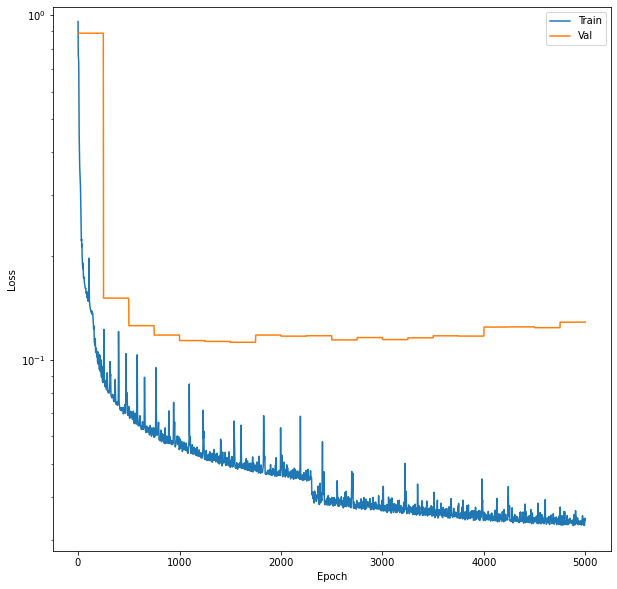

In [4]:
# Train/val loss fig
plt.figure(figsize=(10,10))
plt.plot(range(len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(len(val_loss_list)), val_loss_list, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim(0,1.1*train_loss_list[0])
plt.show()

In [5]:
# Load model
# model = CVAEv1(**configs['model_params'])
model = CVAEv2(**configs['model_params'])

model.load_state_dict(torch.load(f'runs/{model_type}/{split}/{fname}/best_model.pt', map_location=configs['device']))
model = model.to(configs['device'])
model.eval()

# Load test set
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
_, _, test_dataset = dataset.train_val_test_split(mode=split, both_graph_feat_present=True, random_state=0) # Note, here we filter out points with no graph/feature present for either zeolite and OSDA

# Get test zeolites and OSDAs
zeo_code, zeo, osda_smiles, osda, = test_dataset[3], test_dataset[5], test_dataset[13], test_dataset[15], 

# Predict synthesis conditions
zeo_code = repeat(np.array(zeo_code), 'n -> (repeat n)', repeat = 50)
zeo = repeat(zeo, 'n d -> (repeat n) d', repeat = 50)
osda_smiles = repeat(np.array(osda_smiles), 'n -> (repeat n)', repeat = 50)
osda = repeat(osda, 'n d -> (repeat n) d', repeat = 50)
zeo, osda = zeo.to(configs['device']), osda.to(configs['device'])
syn_pred = torch.tensor(model.predict(zeo, osda).cpu().detach().numpy())

# Scale synthesis conditions back
for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
    qt = dataset.qts[ratio] # load quantile transformer
    syn_pred[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_pred[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
syn_pred = pd.DataFrame(syn_pred, columns=dataset.ratio_names+dataset.cond_names)
syn_pred['zeo'], syn_pred['osda'] = zeo_code, osda_smiles
syn_pred.to_csv(f'runs/{model_type}/{split}/{fname}/syn_pred_agg.csv', index=False) # Save synthetic predictions
syn_pred.shape

SYSTEMS:
train: 1624 val: 232 test: 464

n_datapoints:
train: 14788 val: 2068 test: 5168


(258400, 14)

In [6]:
# Get ground truth
syn_true, zeo_code, osda_smiles = test_dataset[1], test_dataset[3], test_dataset[13]
for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
    qt = dataset.qts[ratio] # load quantile transformer
    syn_true[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_true[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true['zeo'], syn_true['osda'] = zeo_code, osda_smiles
syn_true.shape

(5168, 14)

# Aggregated

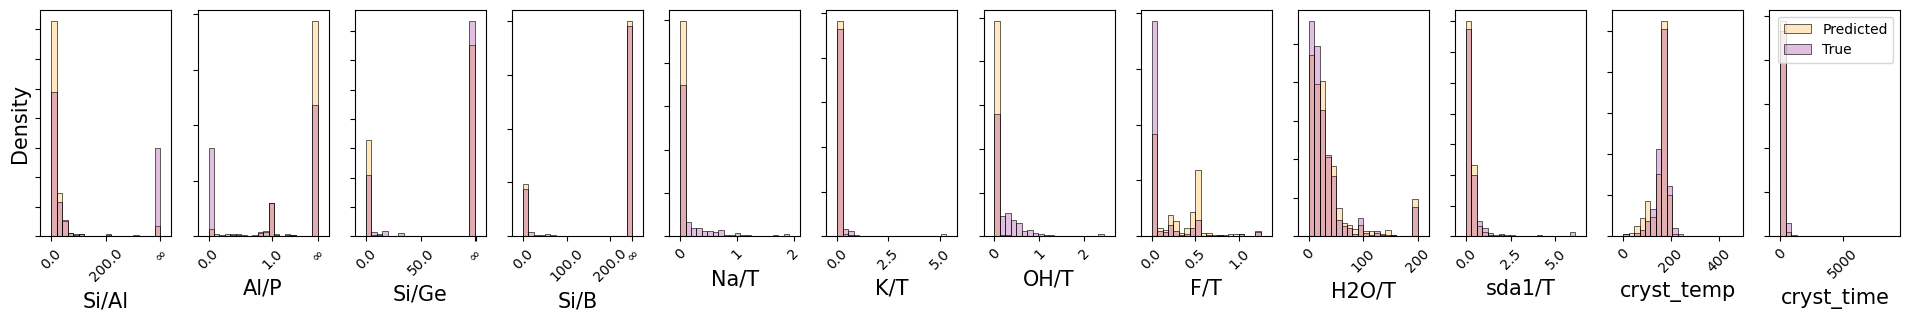

In [7]:
utils.compare_gel_conds([syn_pred, syn_true], ['Predicted', 'True'], ['orange', 'darkmagenta'], kde=False, common_norm=True, alpha=0.25)

# System

### Zeolite-OSDA system

CHA C[N+](C)(C)C12CC3CC(CC(C3)C1)C2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


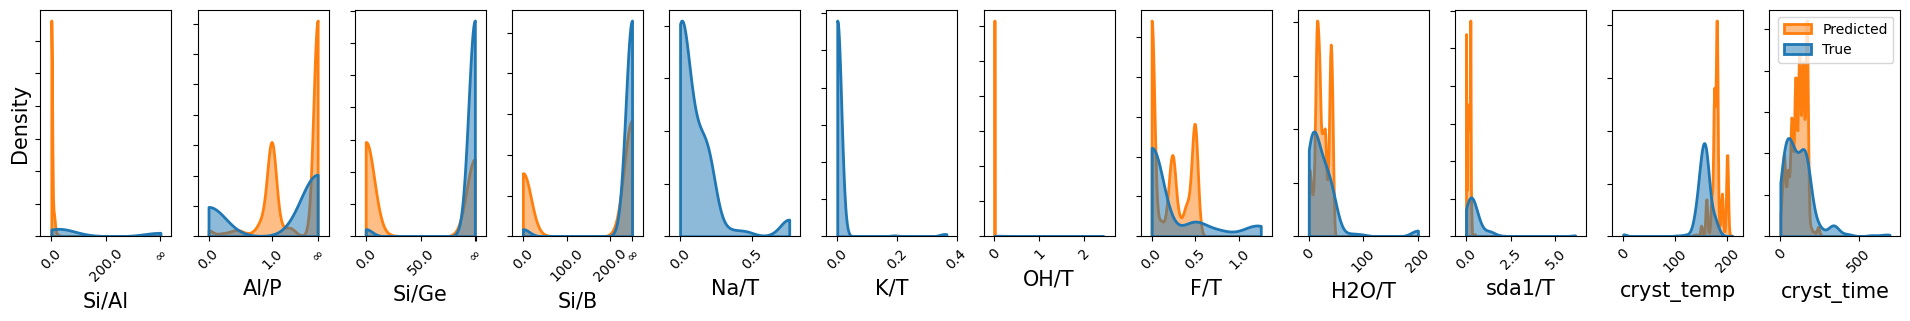

AEL CCCNCCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


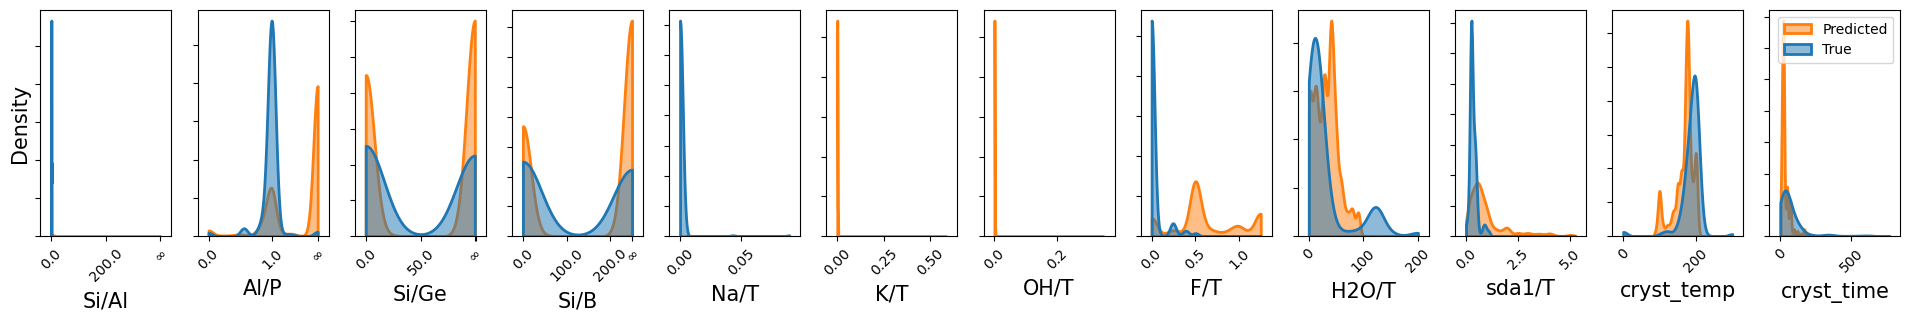

CHA OSDA-free


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


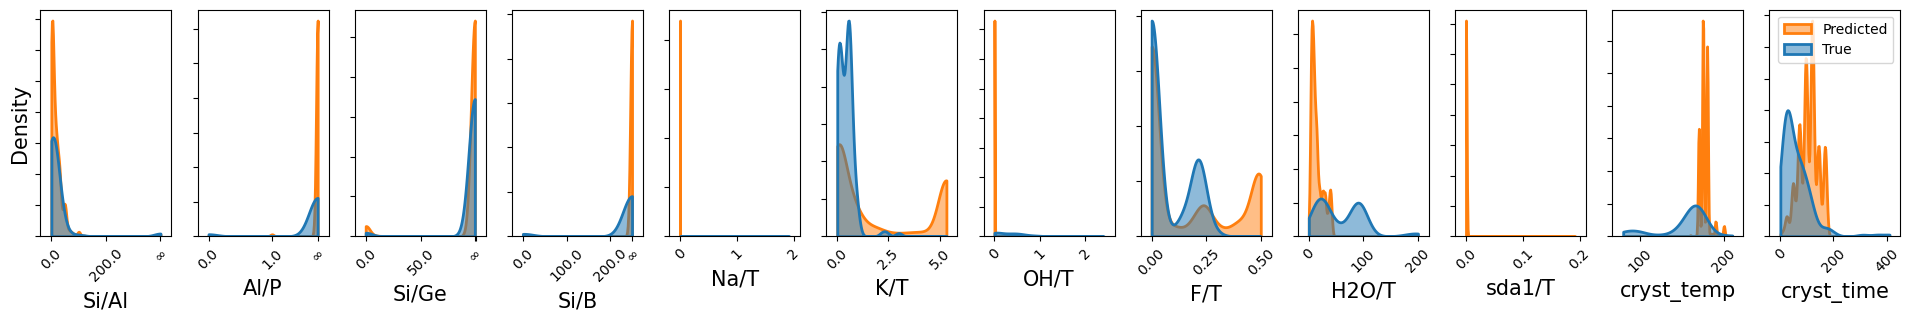

MFI OSDA-free


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


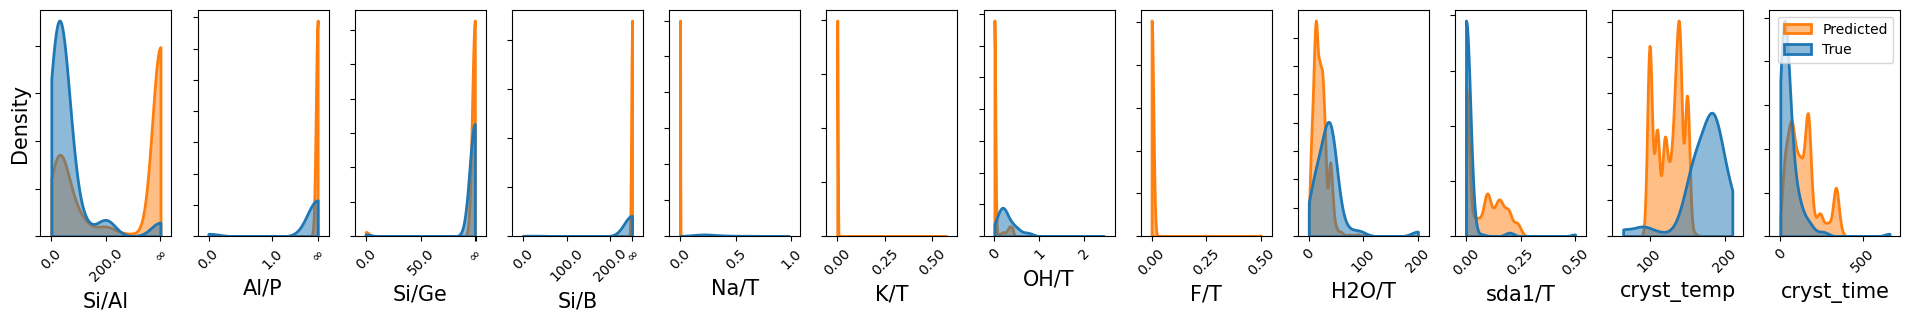

CHA CCN(CC)CC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, 

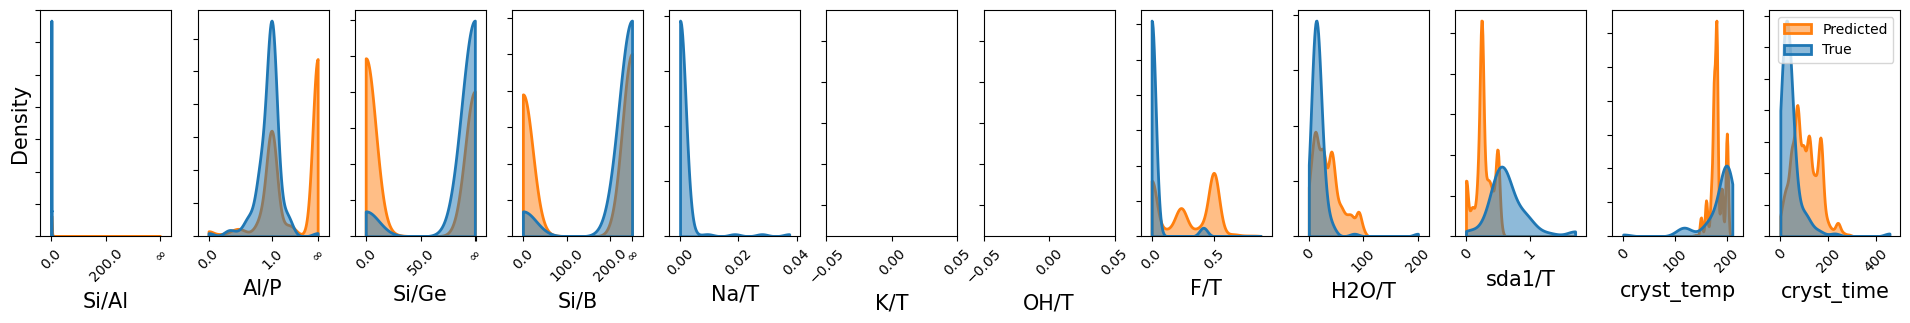

MEL CCCC[N+](CCCC)(CCCC)CCCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


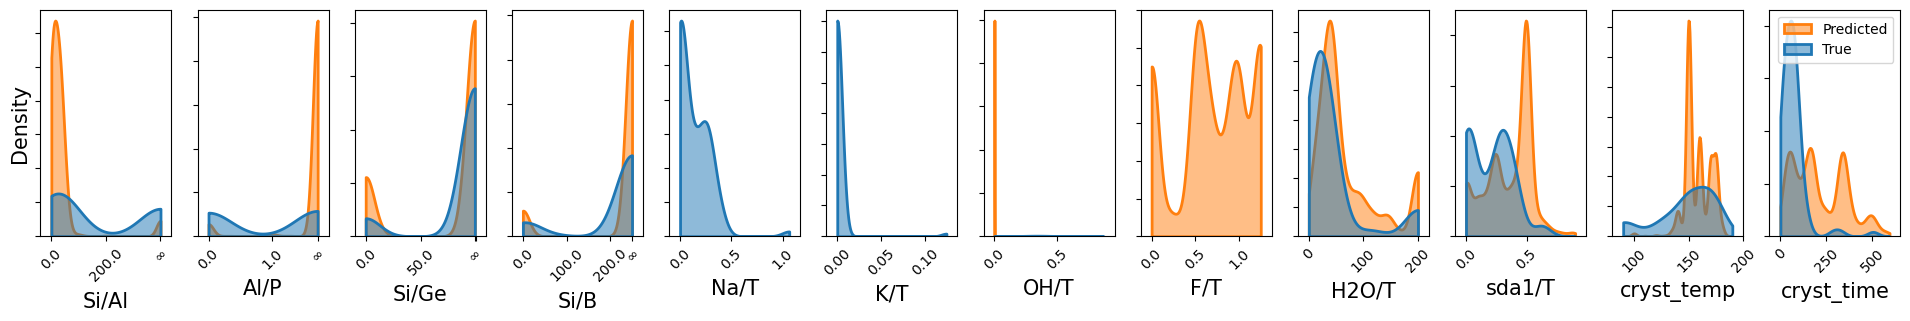

CHA C1COCCN1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

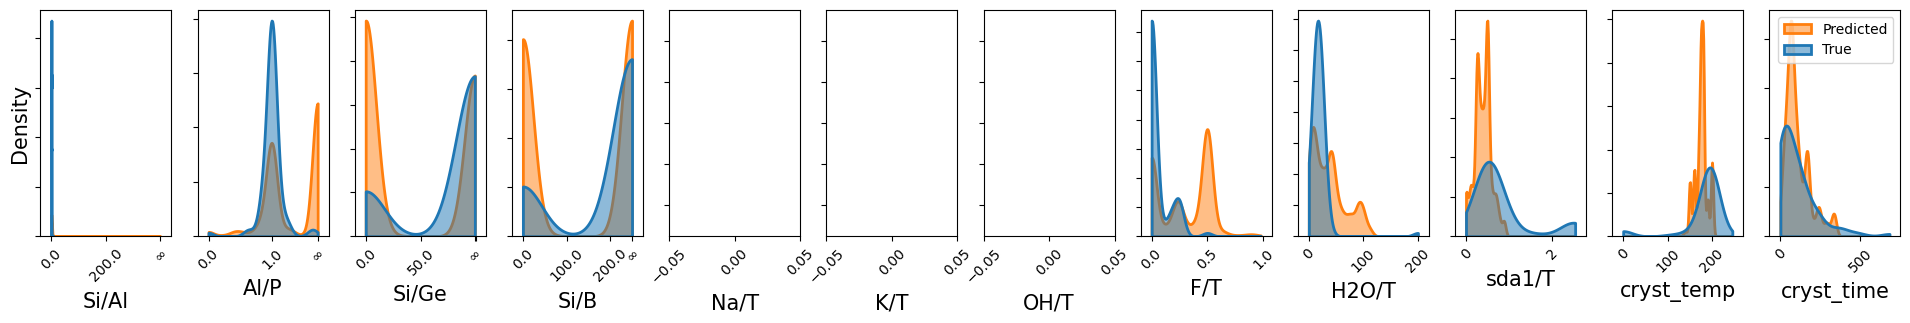

ATO CCCNCCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

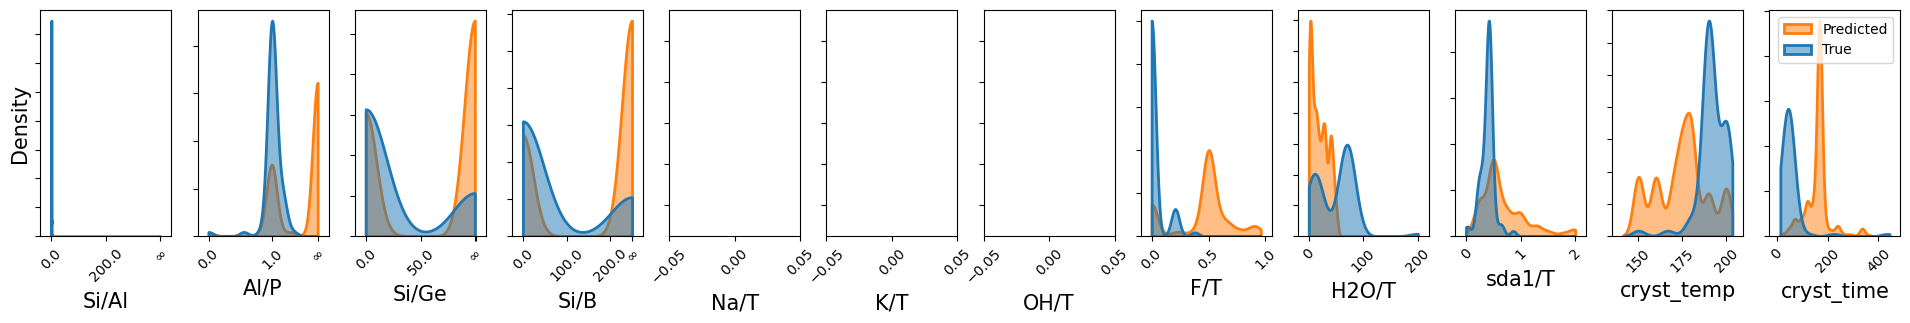

AEI CC1CC(C)C[N+](C)(C)C1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, 

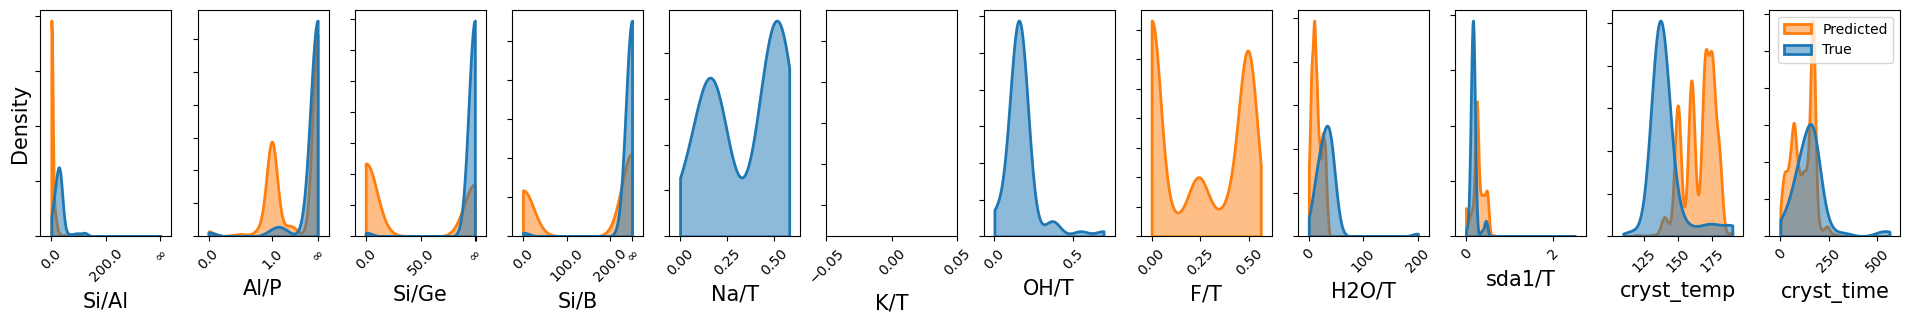

IMF C[N+]1(CCCCC[N+]2(C)CCCC2)CCCC1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

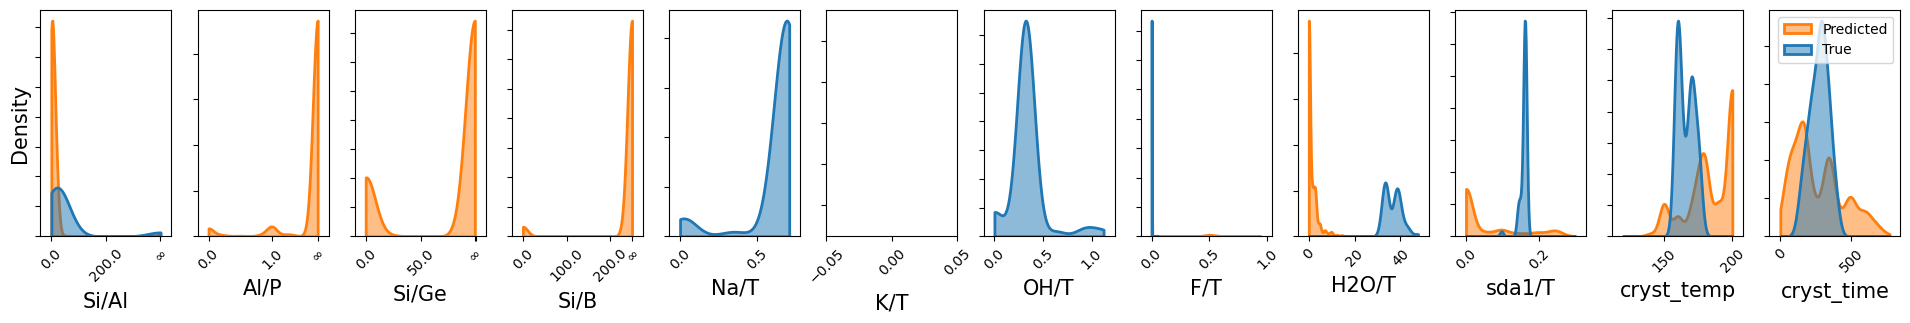

IWR CC[N+]1(CC)CC2C3C(C)=CC(C)(C2C1)C1C[N+](CC)(CC)CC31


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

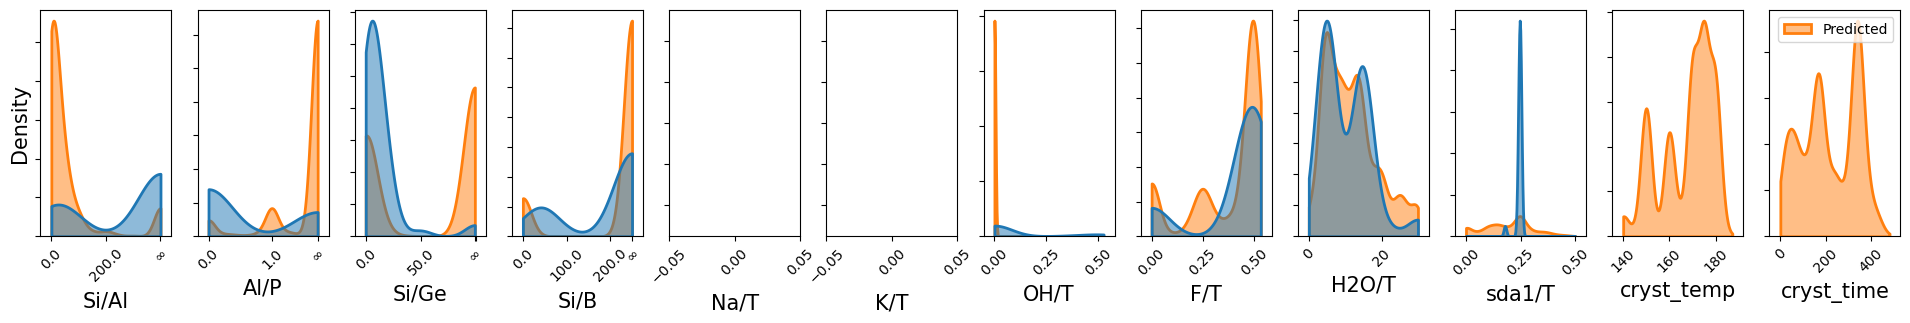

EMT C1COCCOCCOCCOCCOCCO1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


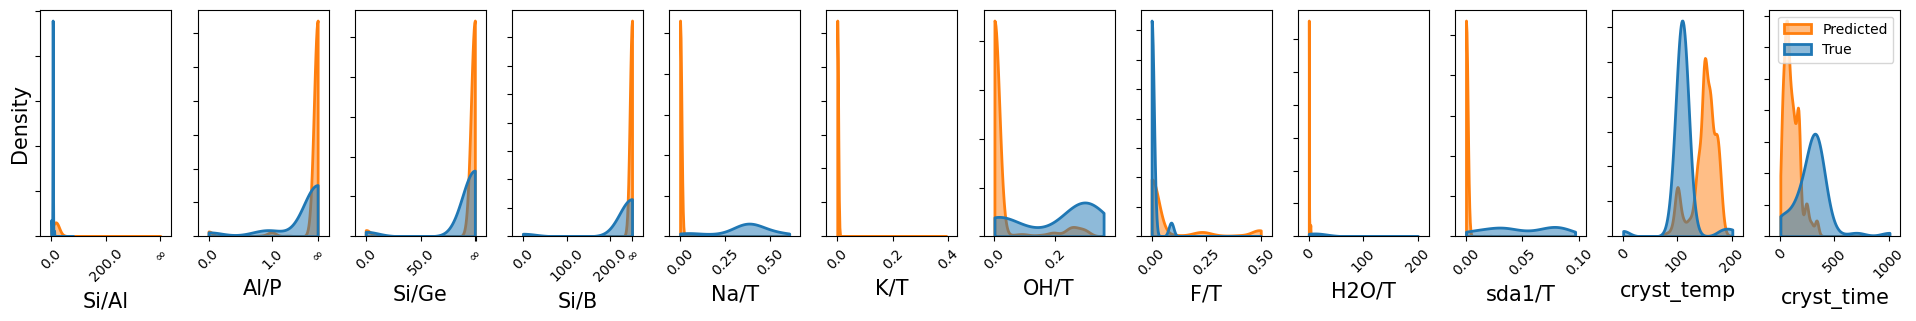

CHA CCNCC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

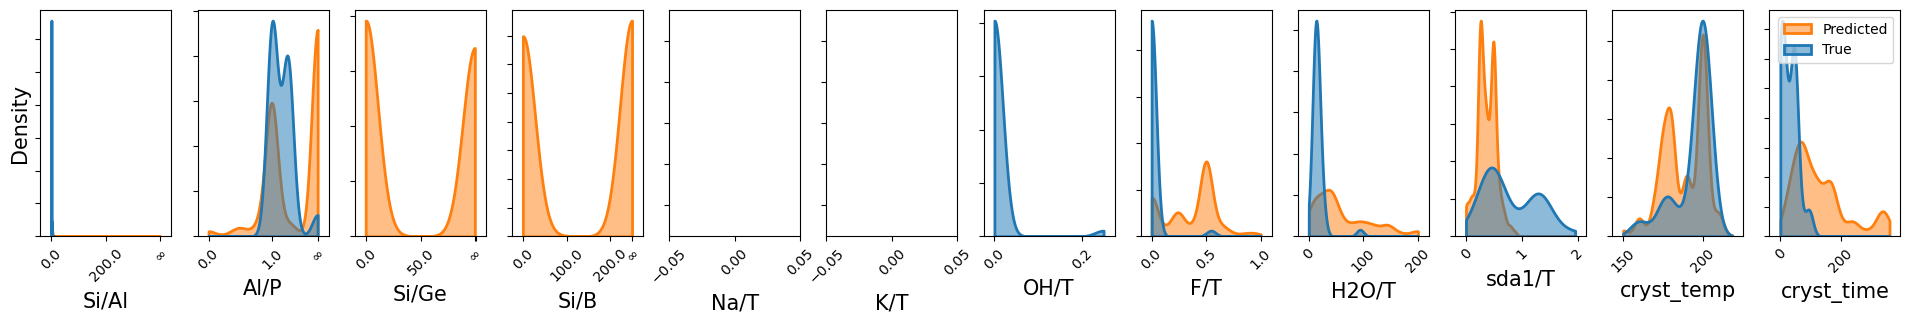

SFO CN(C)c1ccncc1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

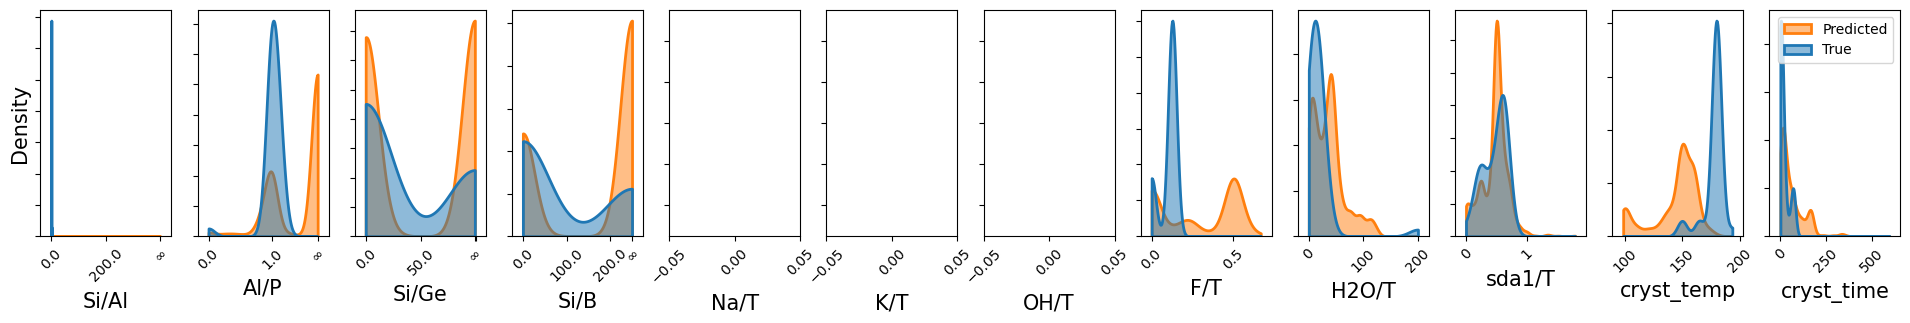

AFI C[N+](C)(C)C12CC3CC(CC(C3)C1)C2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

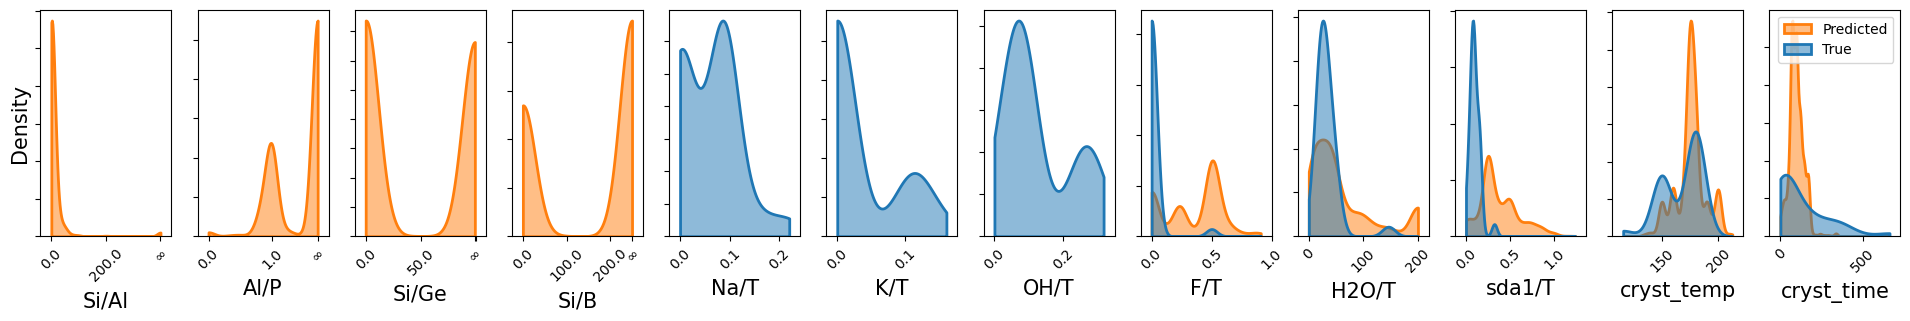

UTL C[C@H]1CCC[C@@H](C)[N+]12CCCC2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

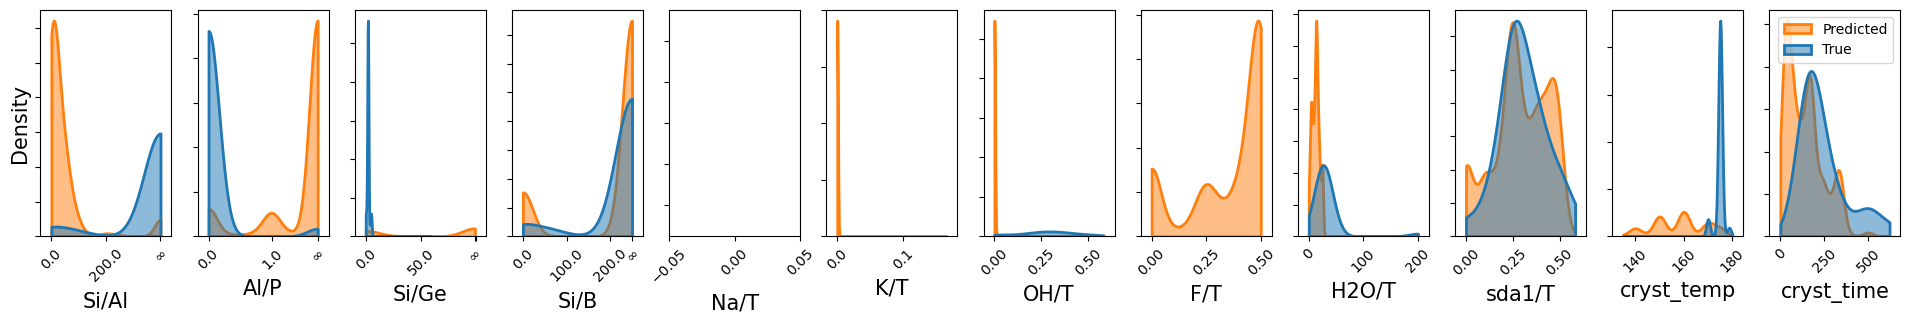

In [8]:
zeo_osda_systems = list(syn_true[['zeo', 'osda']].value_counts().index)
count = 0
for zeo, osda in zeo_osda_systems:
# for zeo, osda in reversed(zeo_osda_systems):
    if zeo != 'Dense/Amorphous':
        print(zeo, osda)
        sys_syn_pred = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)]
        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], ['tab:orange', 'tab:blue'], kde=True, common_norm=True, alpha=0.5, show_hist=False)
        
        count += 1
    if count > 15:
        break

### Zeolite-aggregated systems

CHA


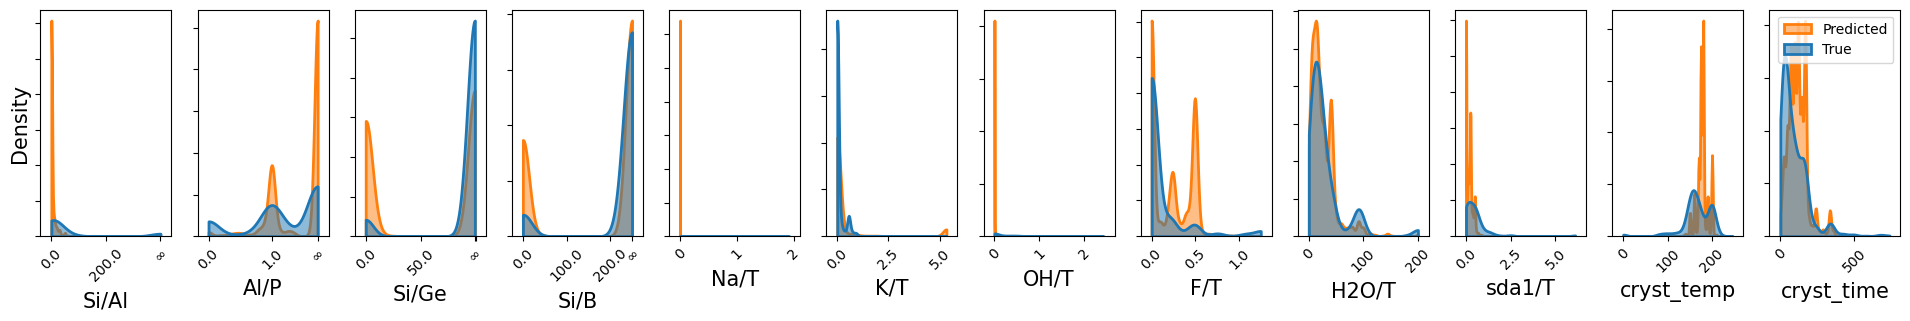

MFI


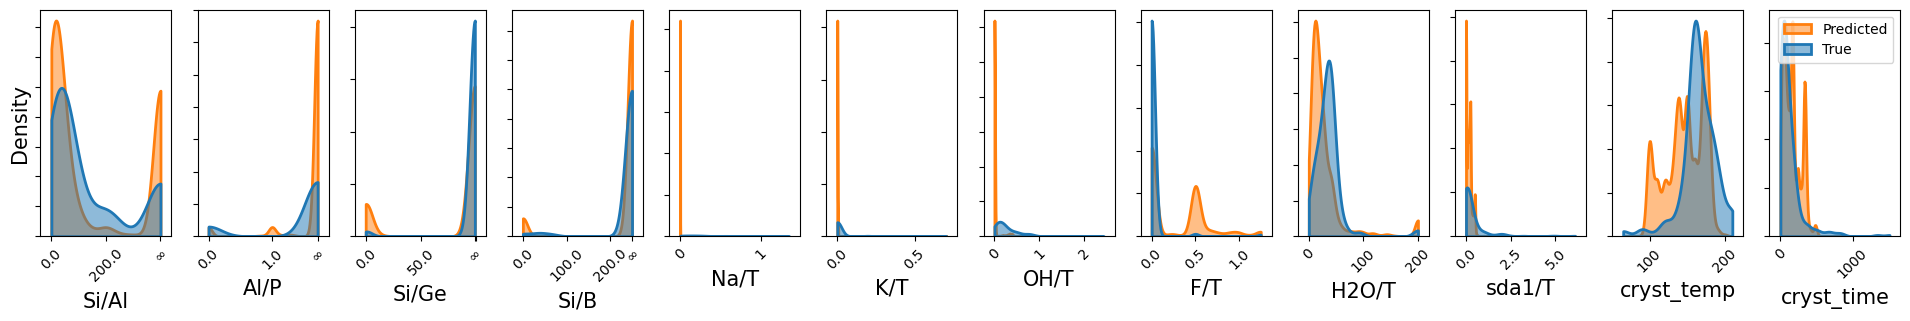

AEL


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


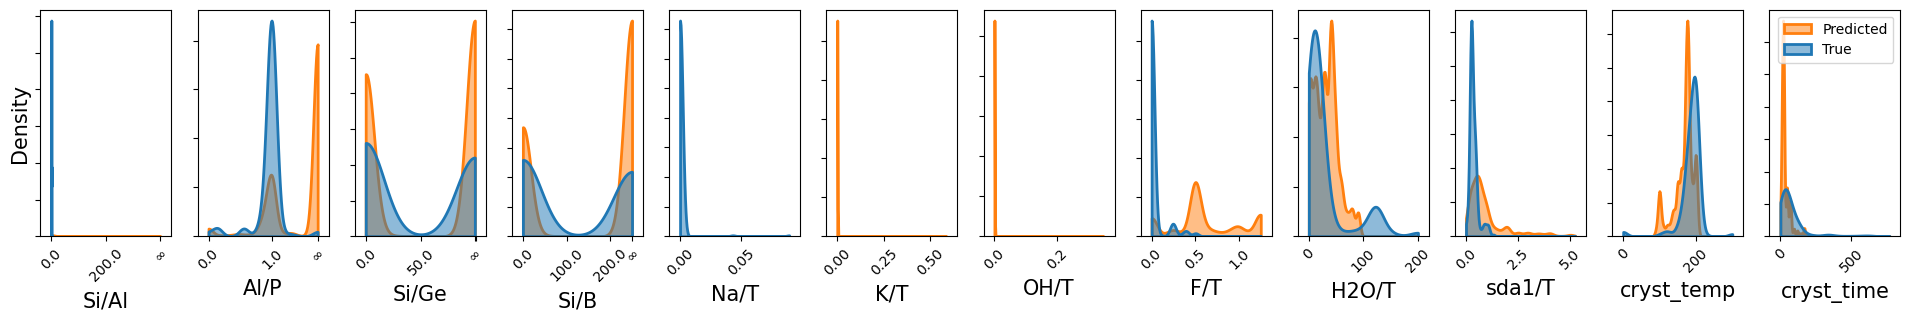

MEL


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


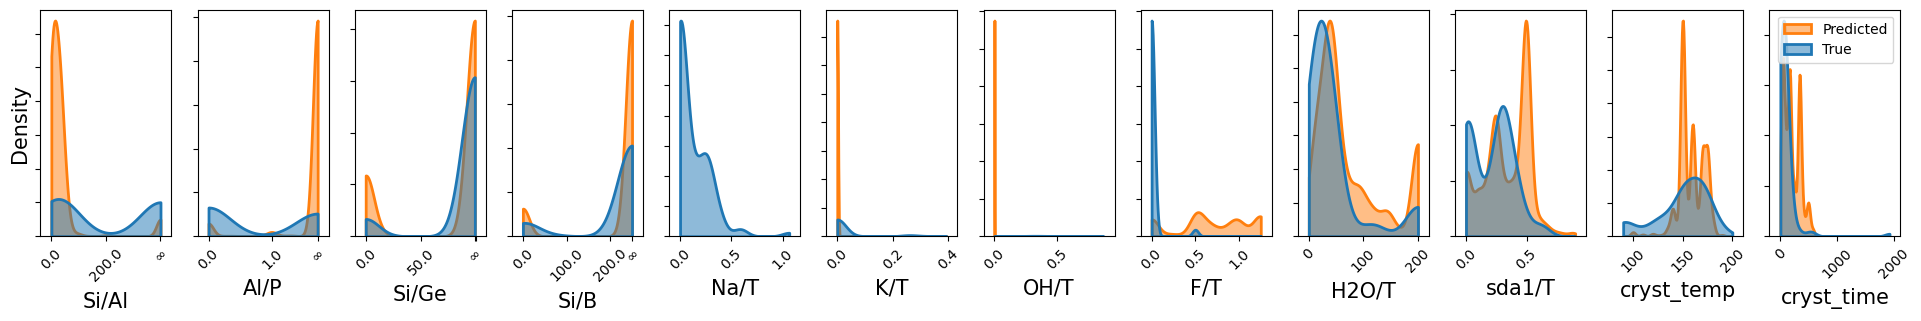

AFI


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


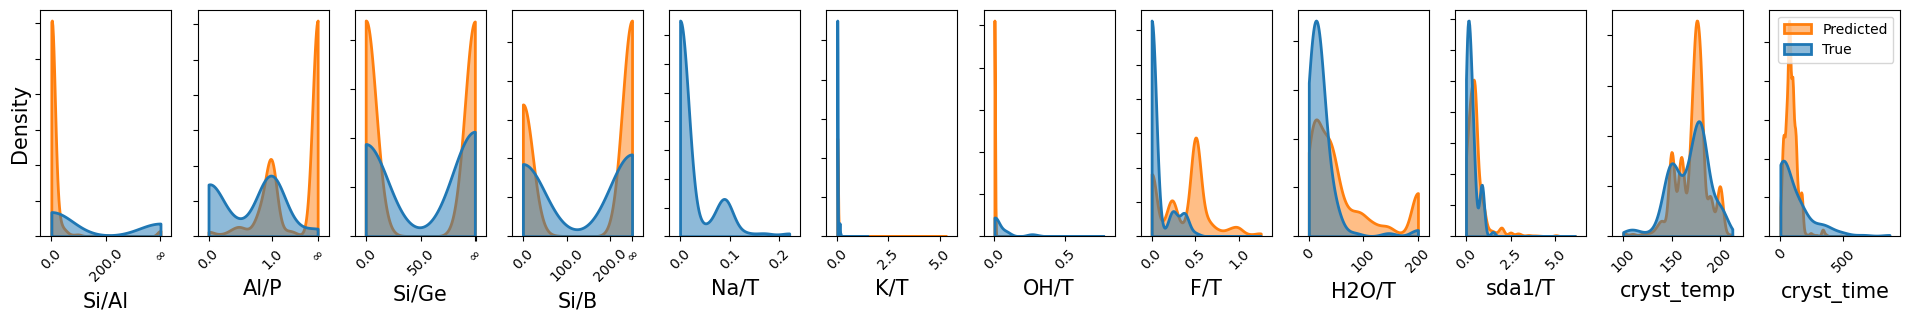

AEI


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, 

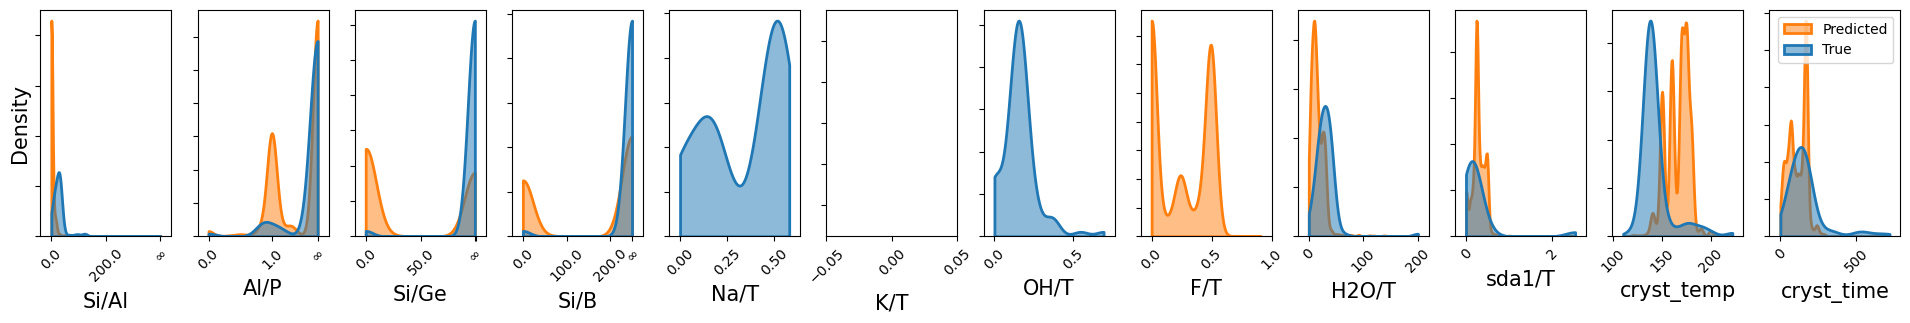

BEA


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


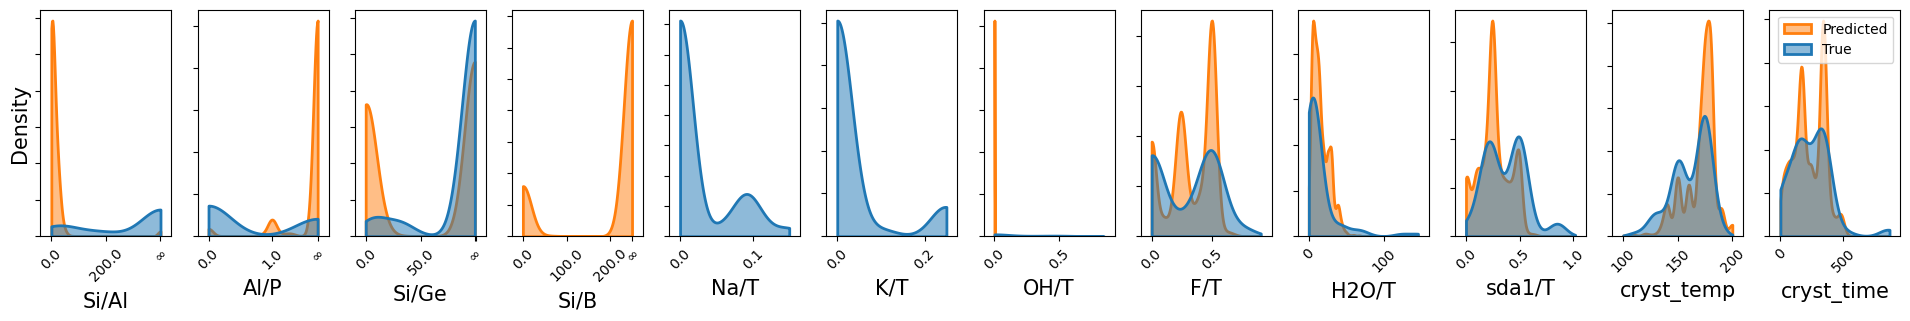

MTW


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


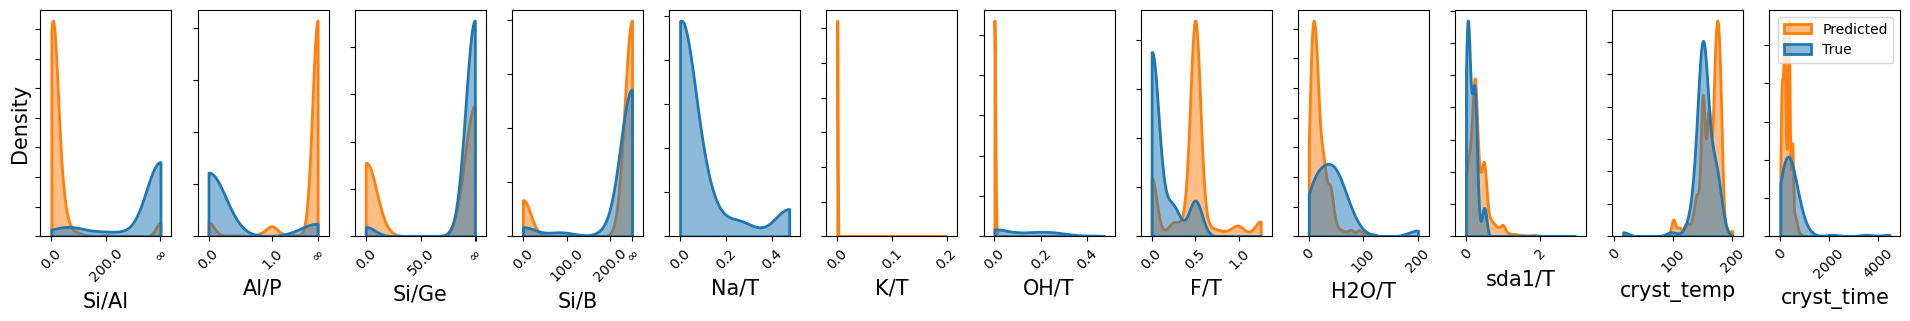

EMT


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


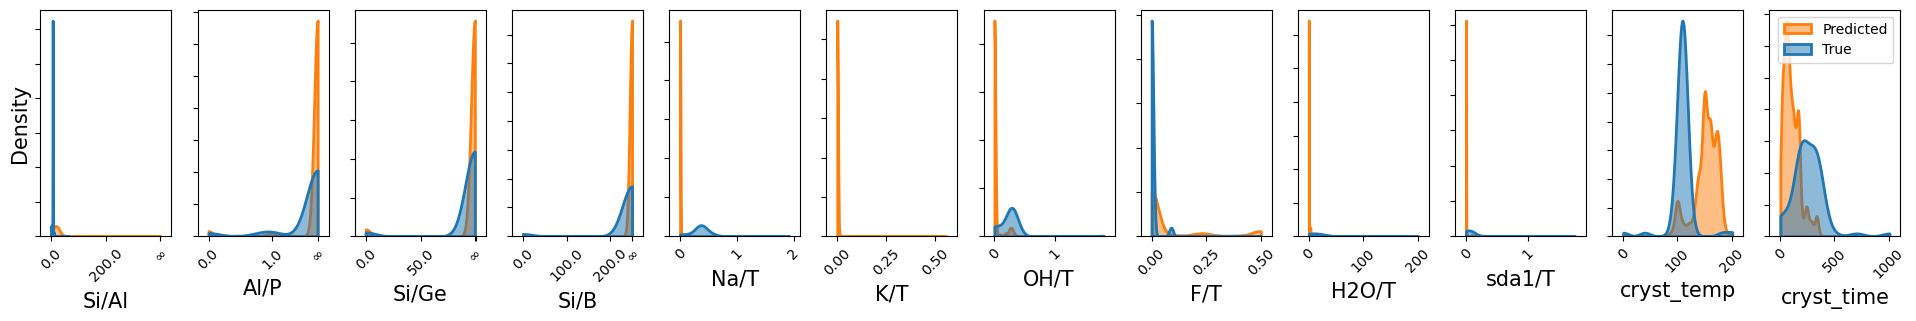

ATO


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

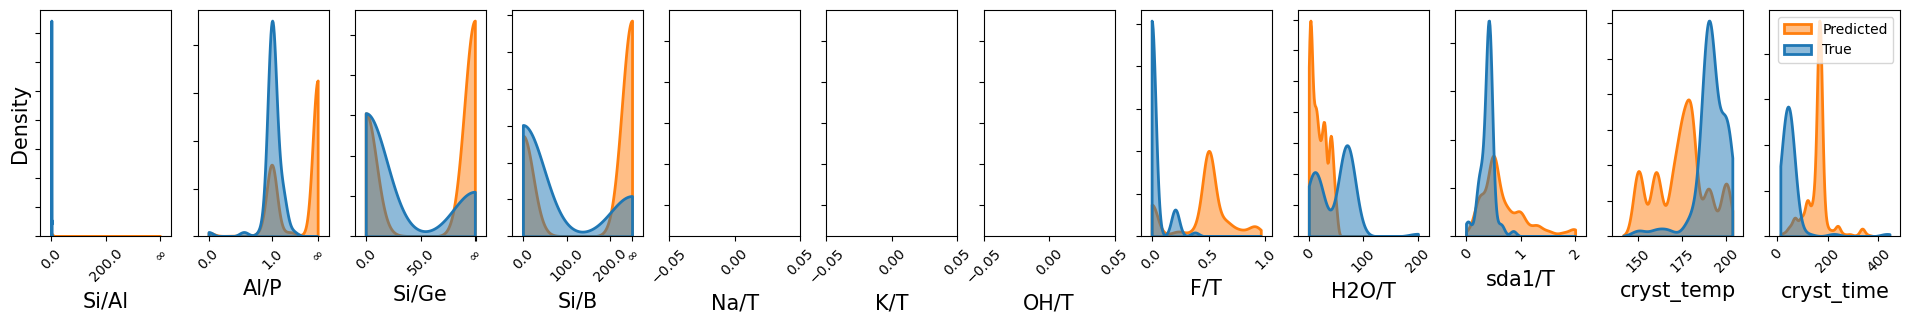

TON


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


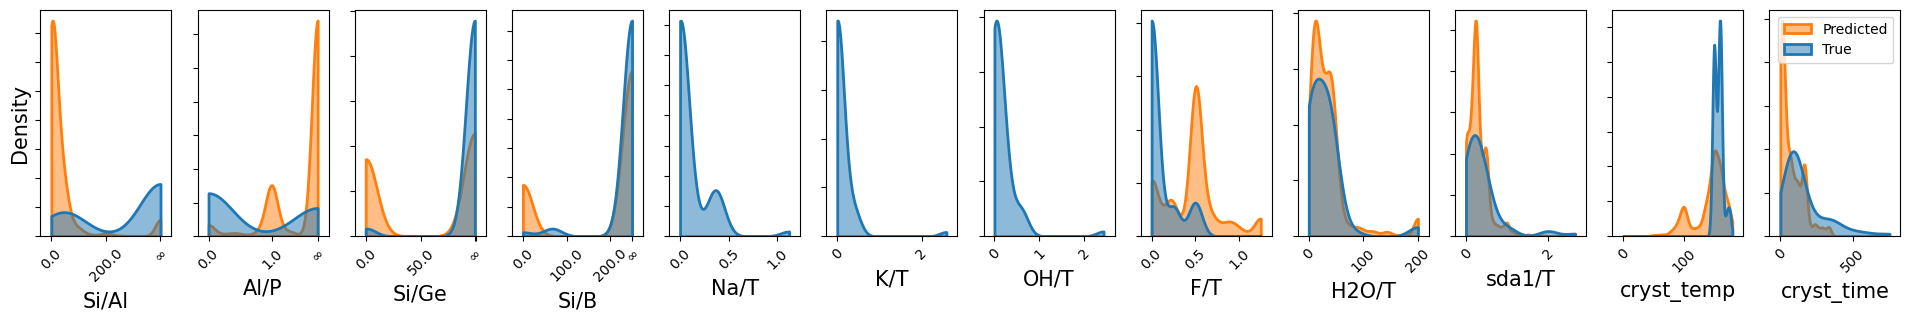

FER


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


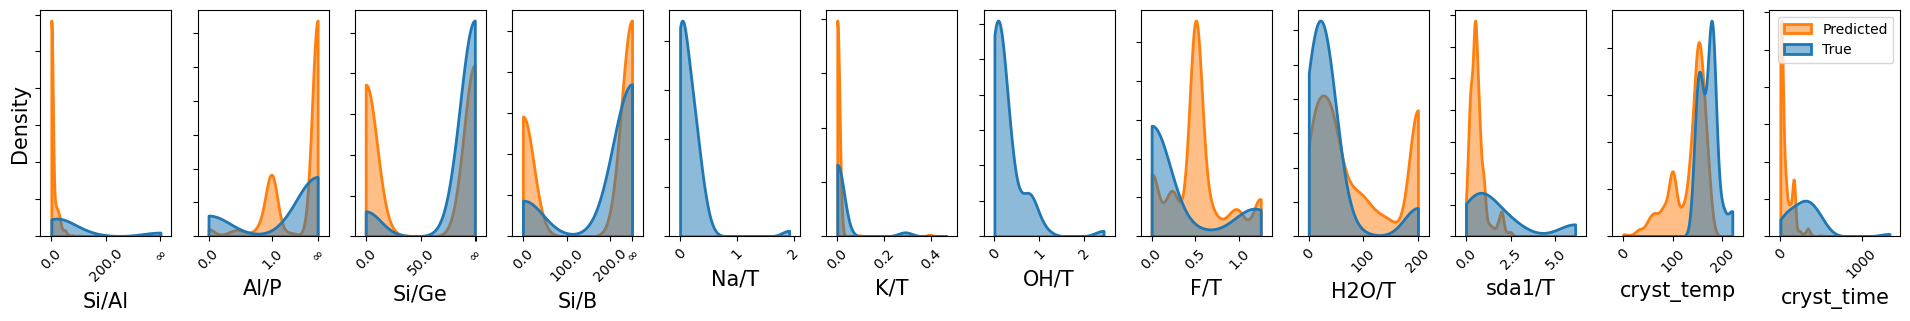

BEC


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

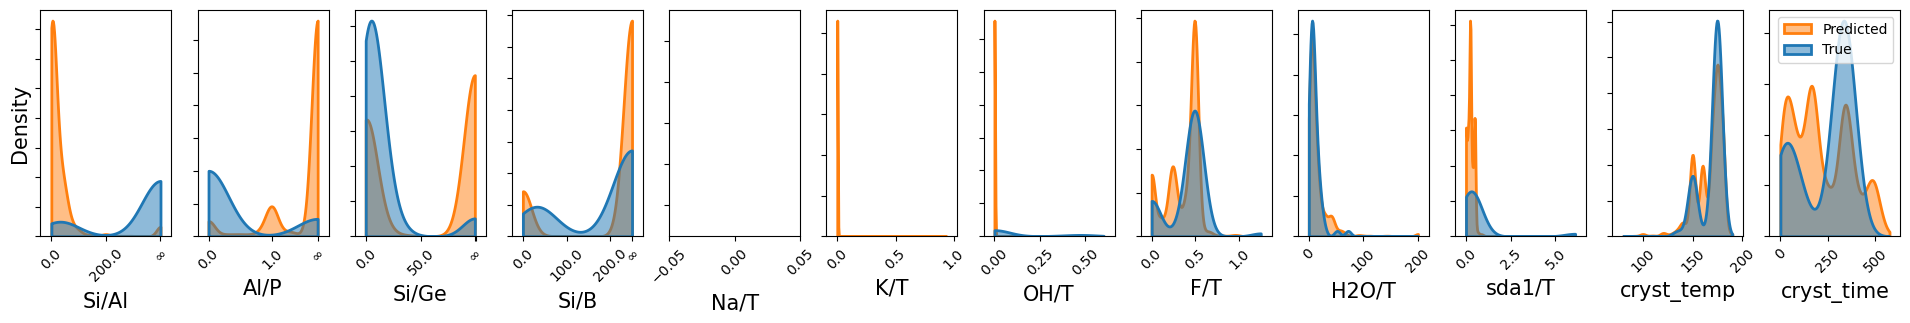

IMF


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

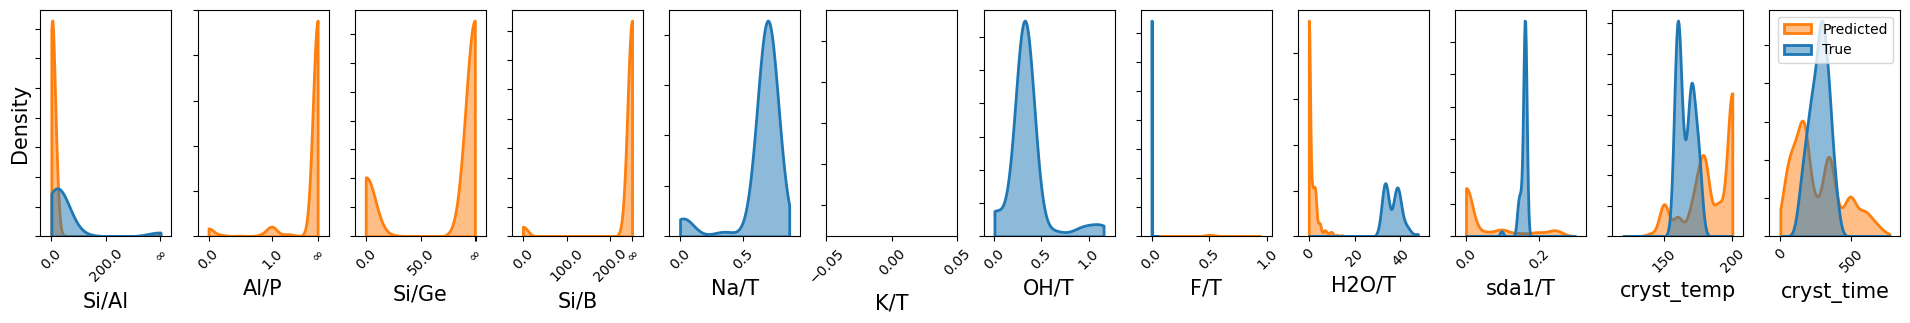

IWR


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

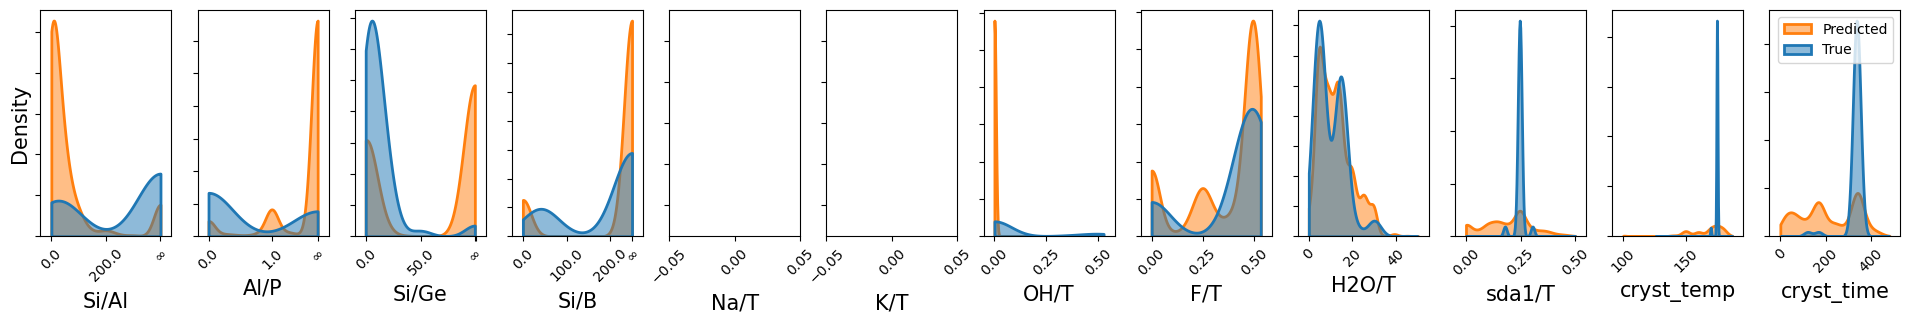

STF


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


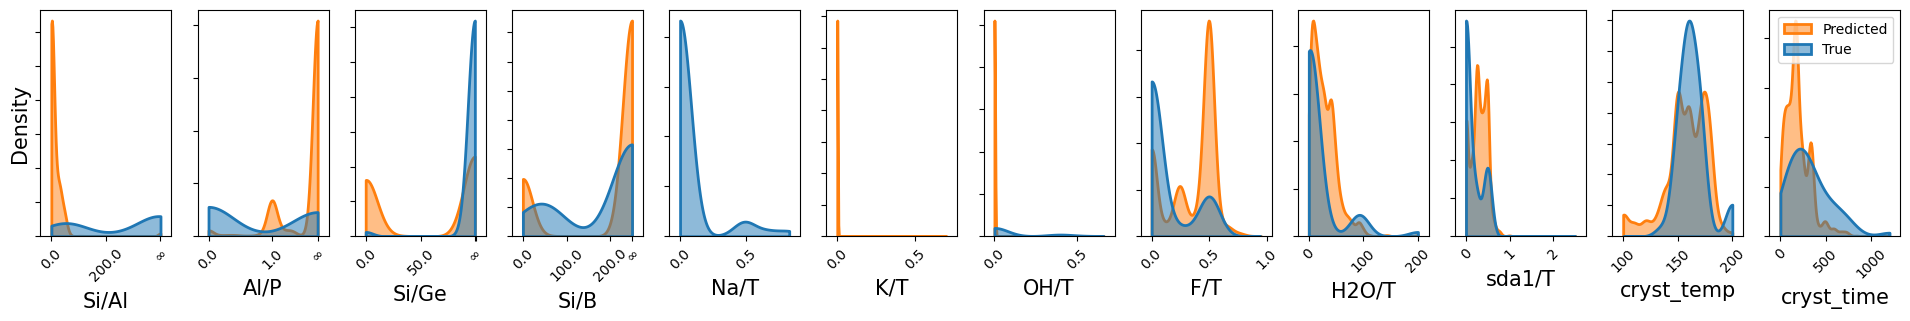

FAU


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

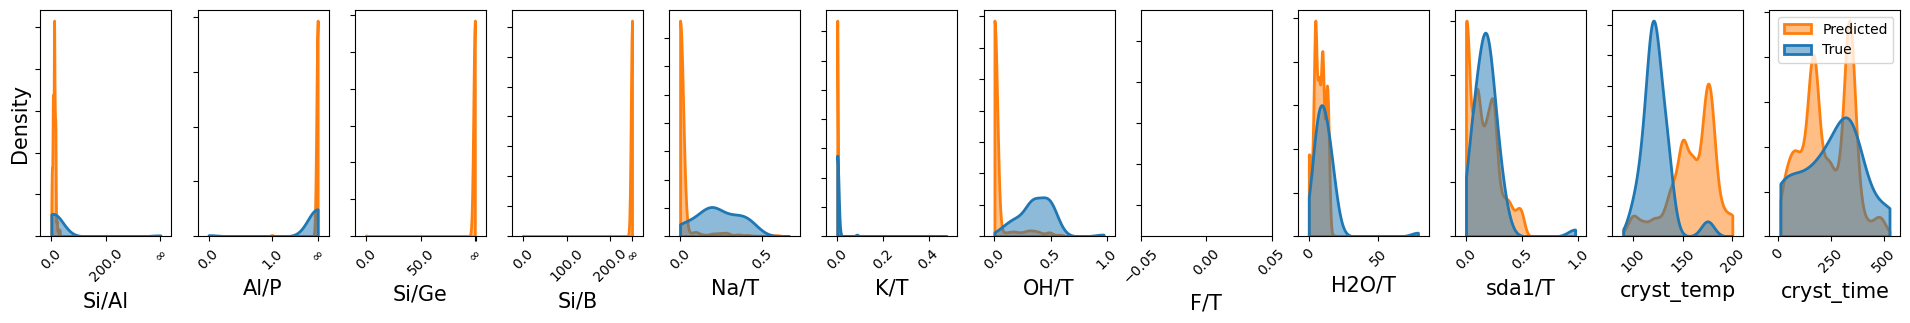

MOR


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

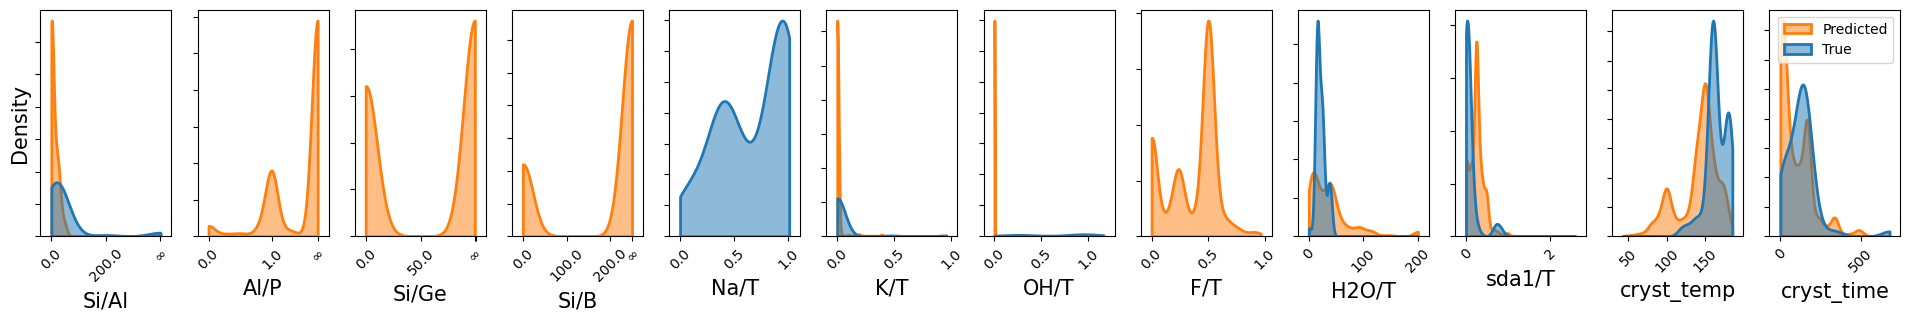

AST


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

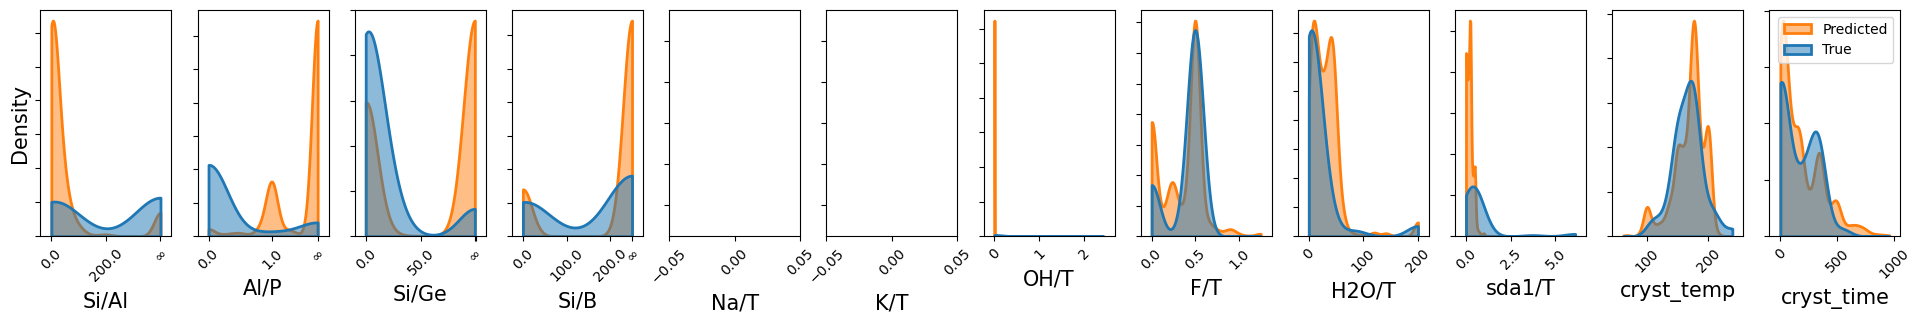

ERI


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

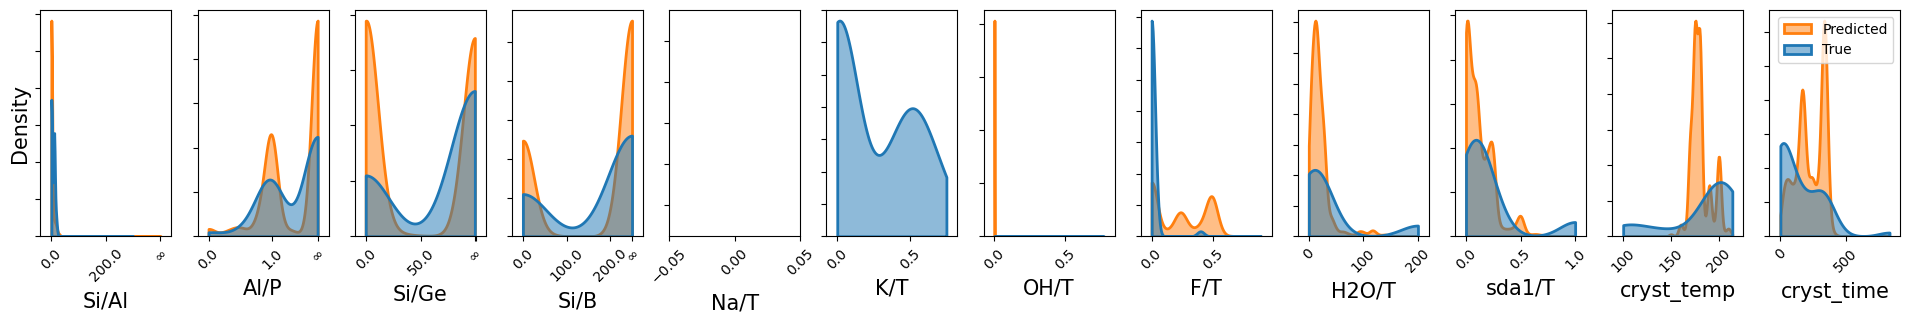

NON


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

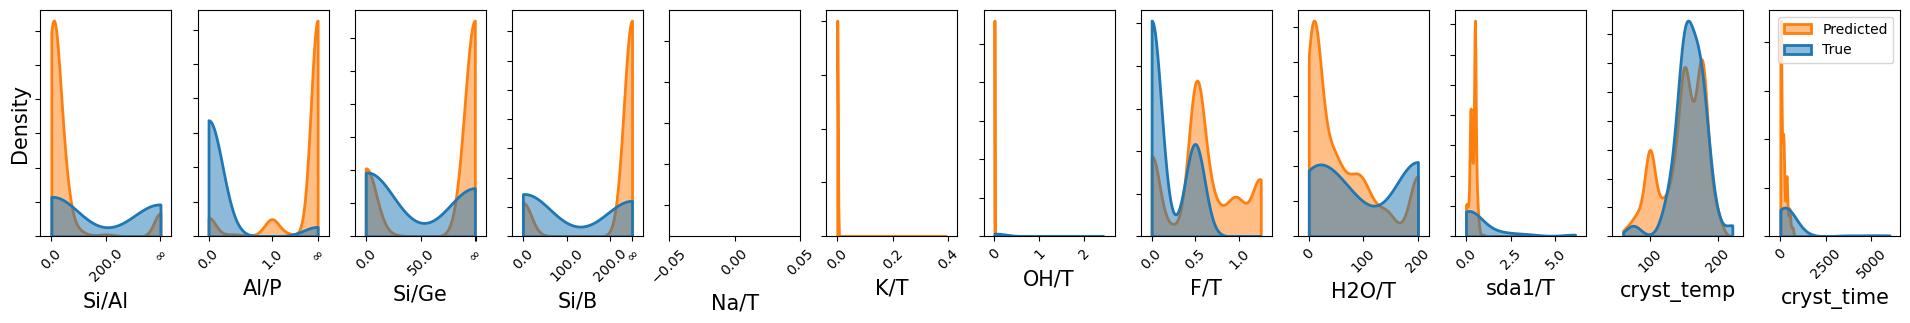

UTL


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

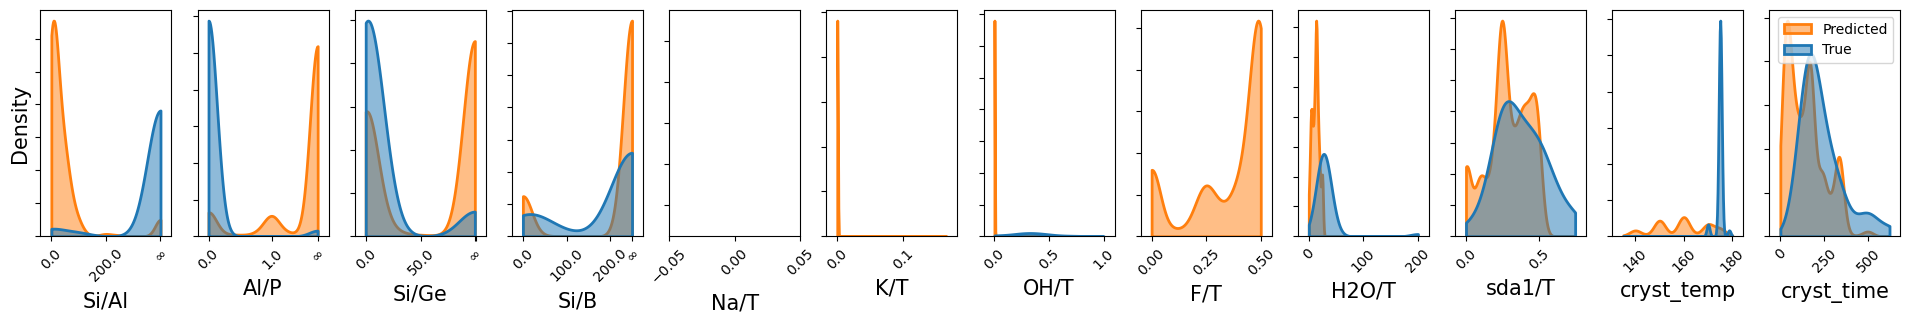

DDR


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

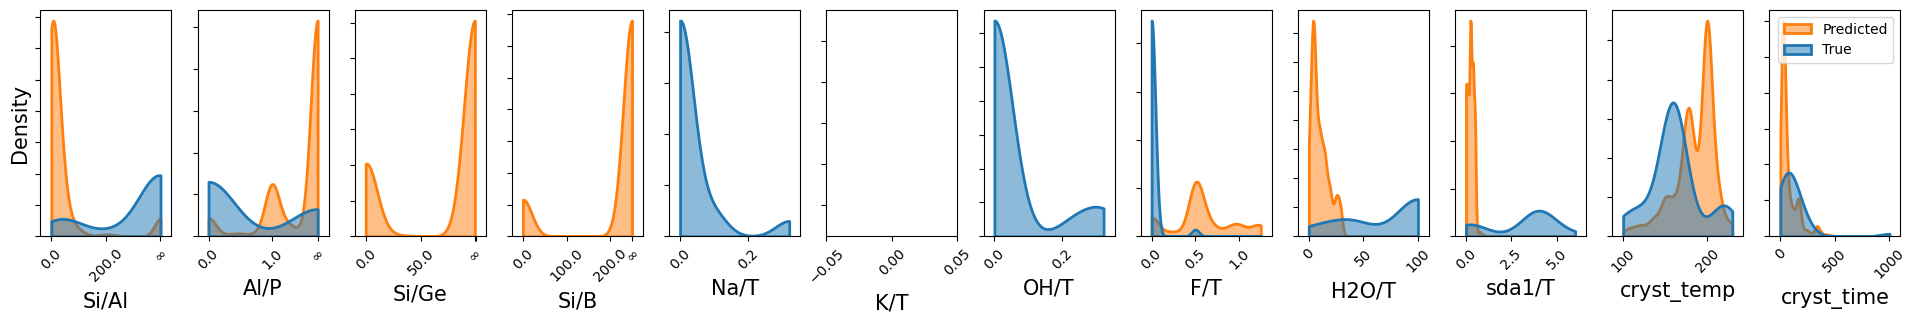

SFO


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.

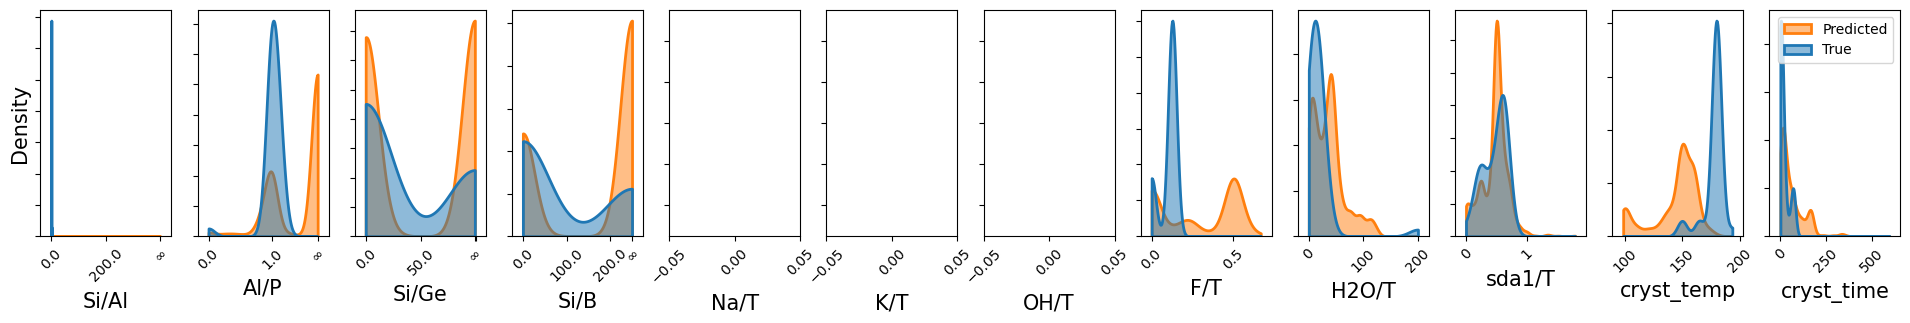

SVY


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

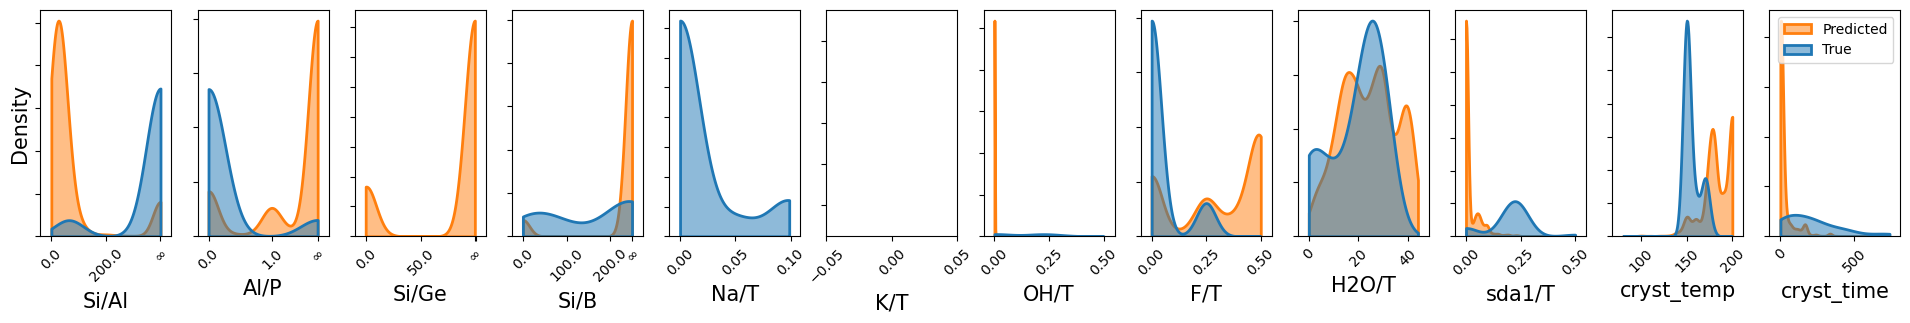

SOD


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


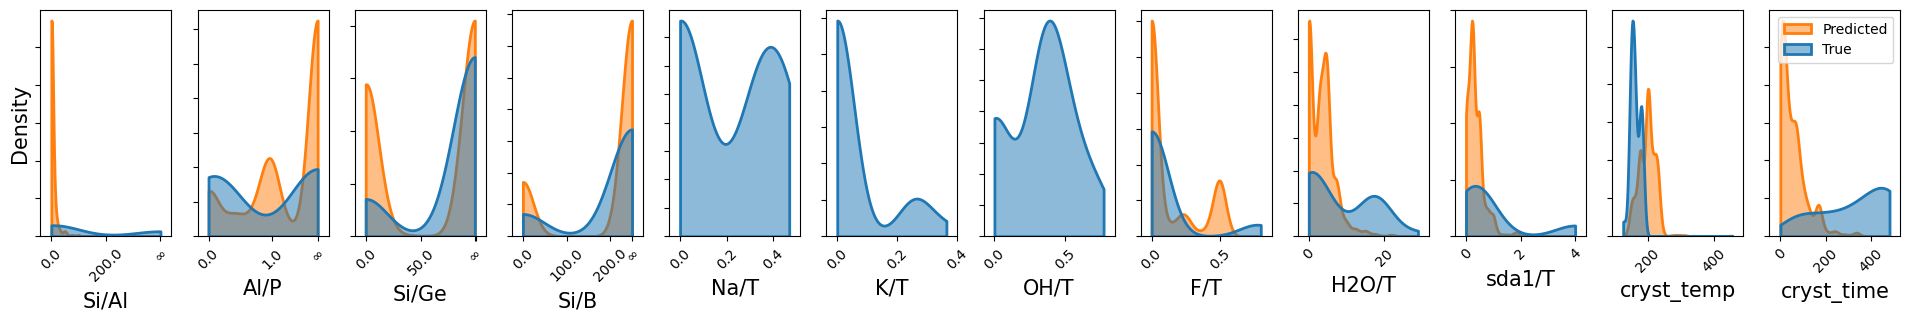

MTT


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

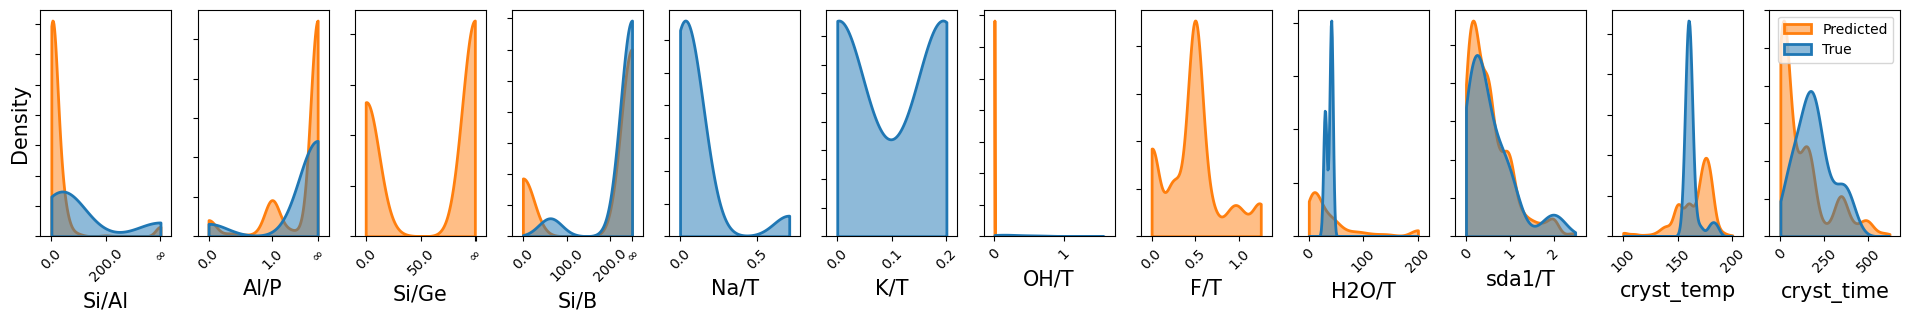

MTN


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


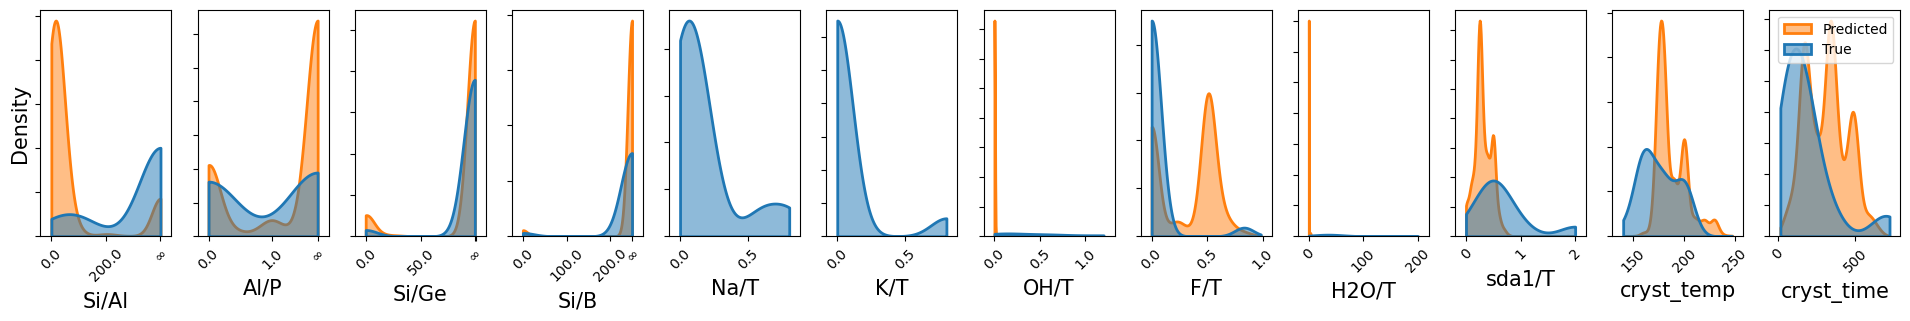

UOV


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

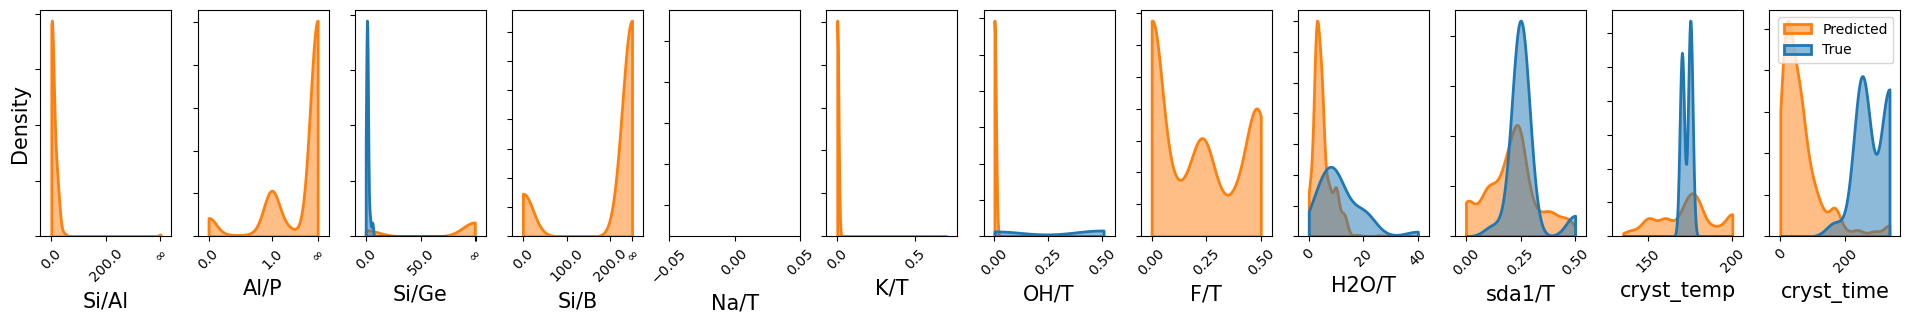

STO


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, 

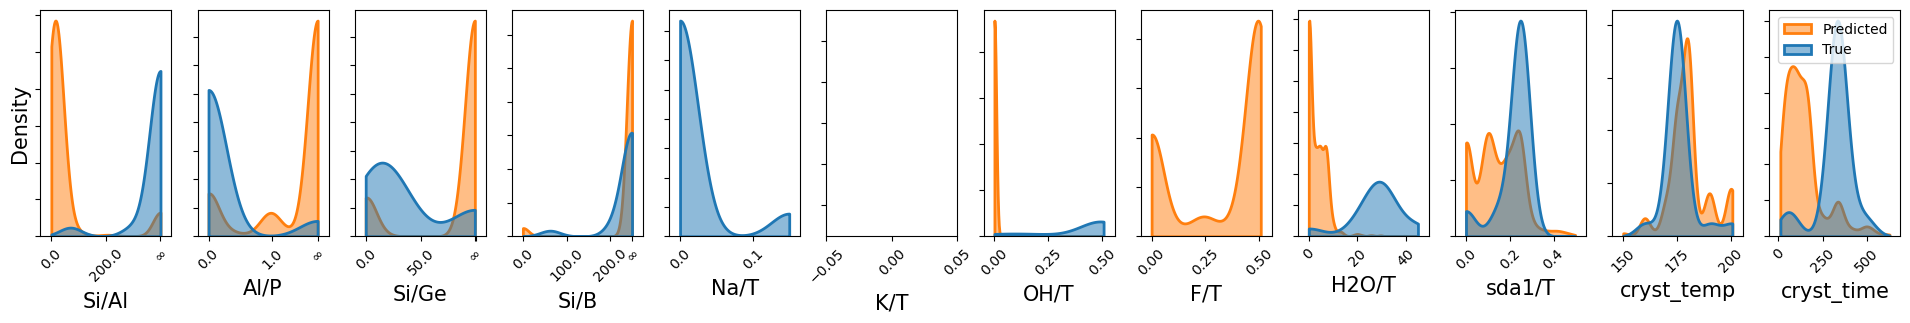

EDI


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this

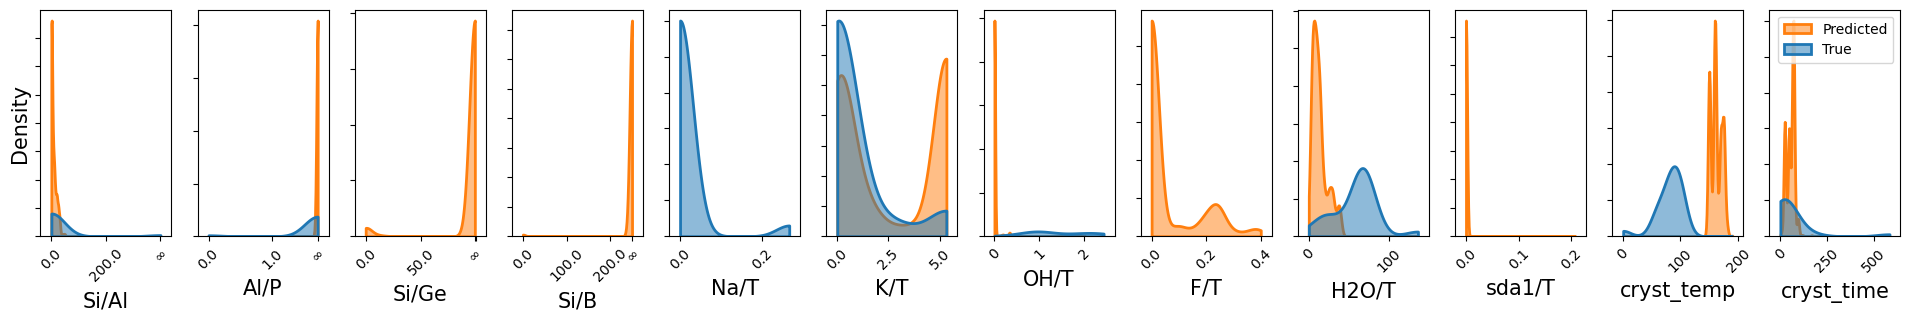

In [9]:
zeo_systems = list(syn_true['zeo'].value_counts().index)
count = 0
for zeo in zeo_systems:
    if zeo != 'Dense/Amorphous':
        print(zeo)
        sys_syn_pred = syn_pred[syn_pred['zeo'] == zeo]
        sys_syn_true = syn_true[syn_true['zeo'] == zeo]
        utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], ['tab:orange', 'tab:blue'], kde=True, common_norm=True, alpha=0.5, show_hist=False)
        
        count += 1
    if count > 30:
        break

### BEC systems

BEC c1ccc(C[N+]23CCC(CC2)CC3)cc1


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


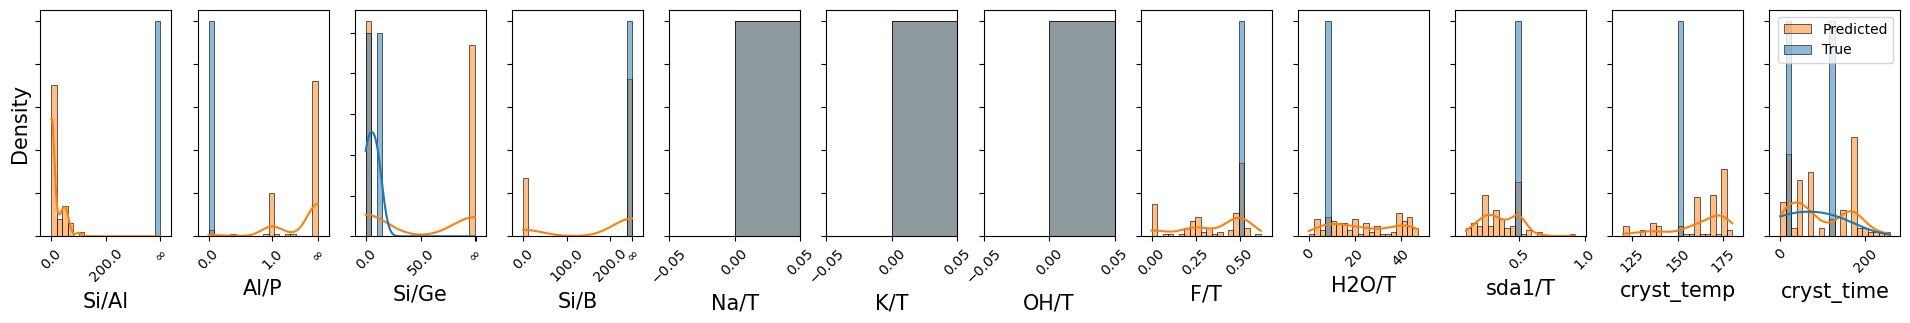

BEC c1cc(C[N+]23CCC(CC2)CC3)ccc1C[N+]12CCC(CC1)CC2


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


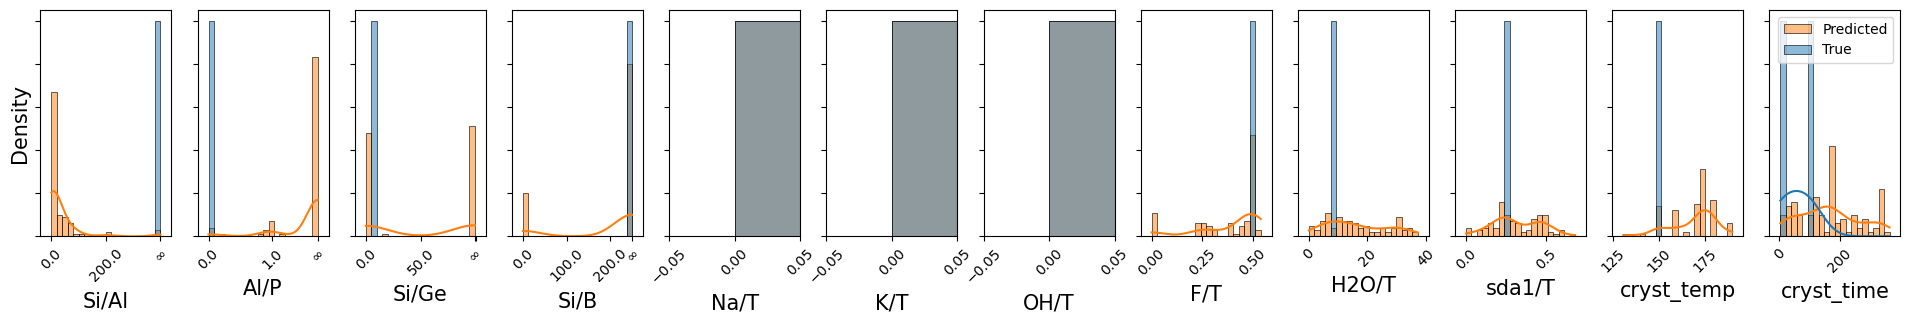

BEC C(CC[N+]12CCN(CC1)CC2)C[N+]12CCN(CC1)CC2


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


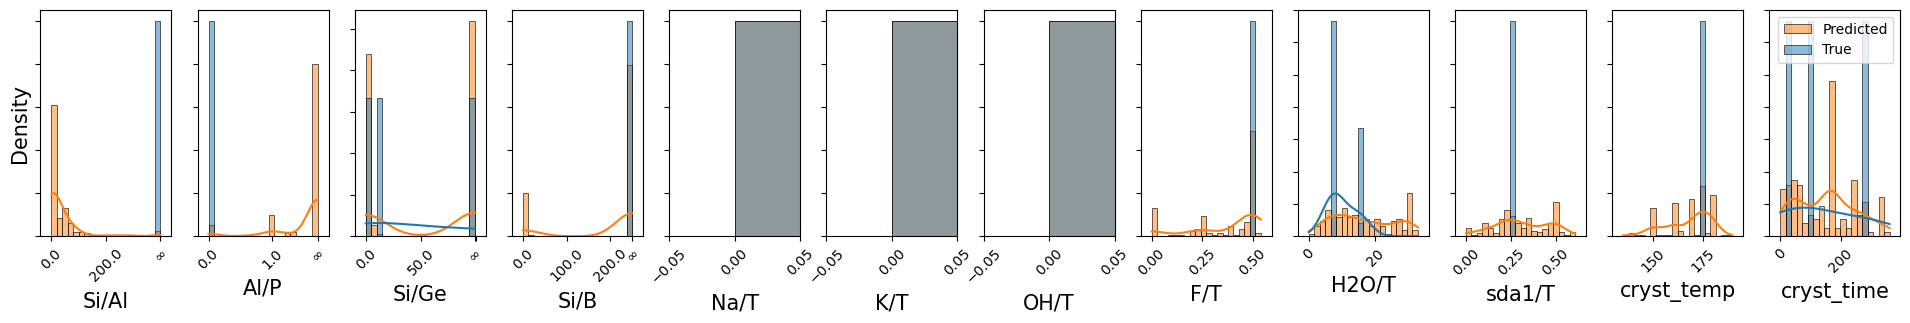

BEC CN(C)CCN(C)C


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


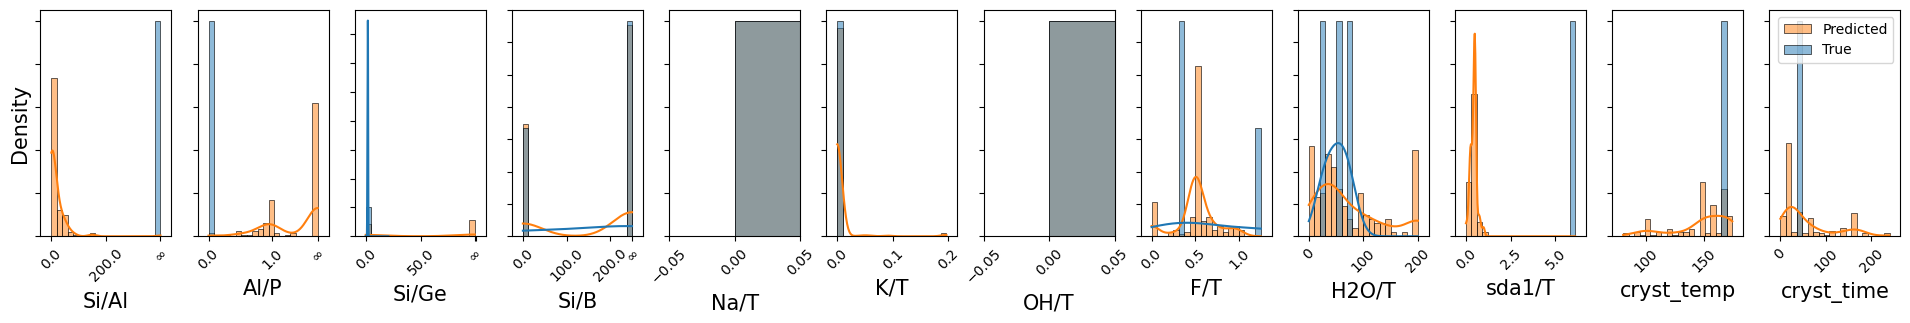

BEC CCC[N+]1(CCC)CCC([N+]2(CCC)CCCC2)CC1


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


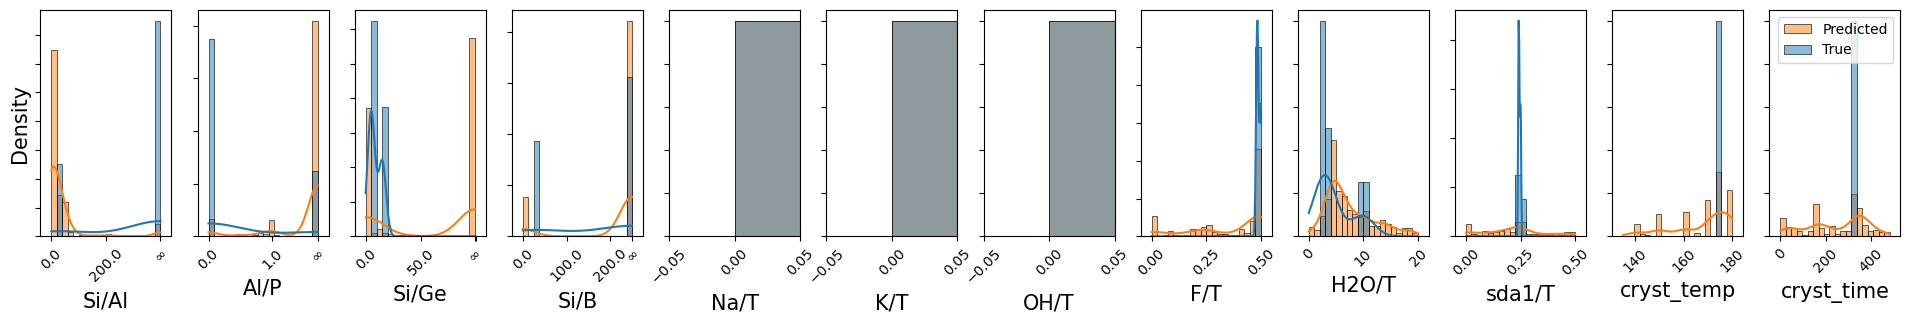

BEC c1ccc(C[N+]23CCN(CC2)CC3)cc1


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


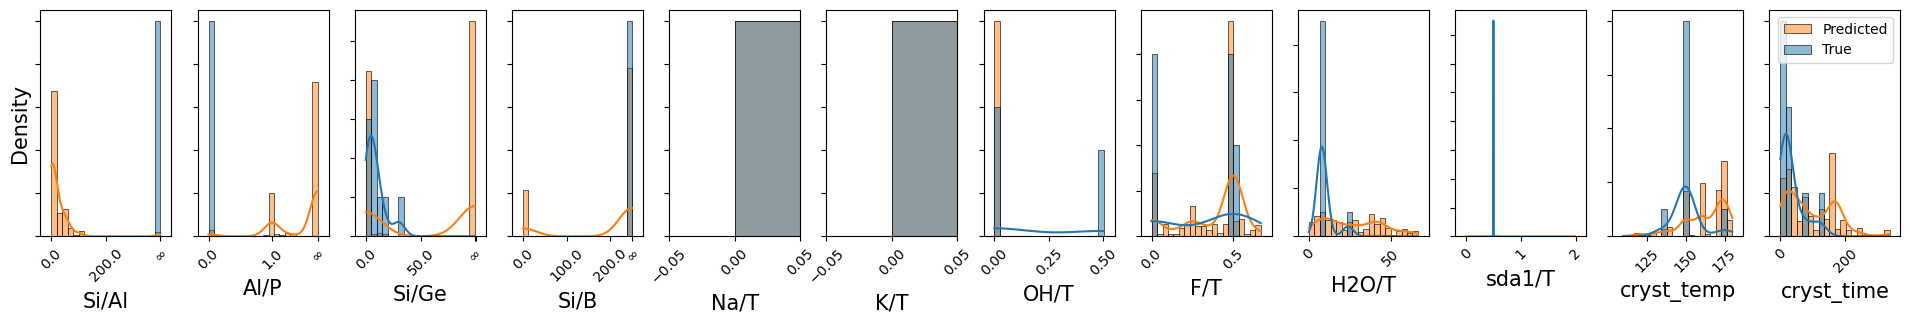

BEC C[N+]1(C)CCC([N+]2(C)CCCC2)CC1


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


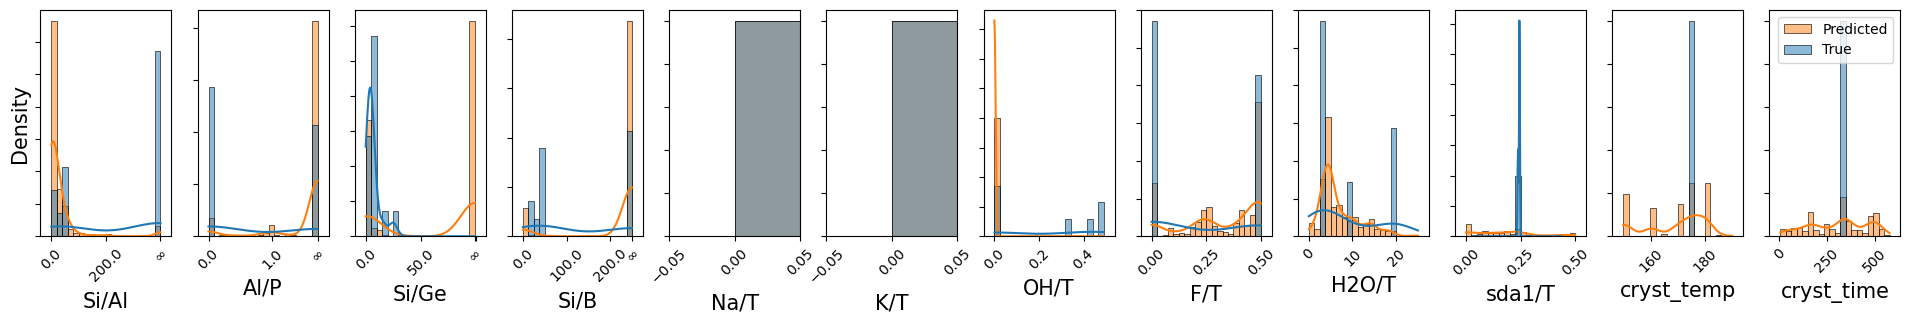

BEC C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31


/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:670: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


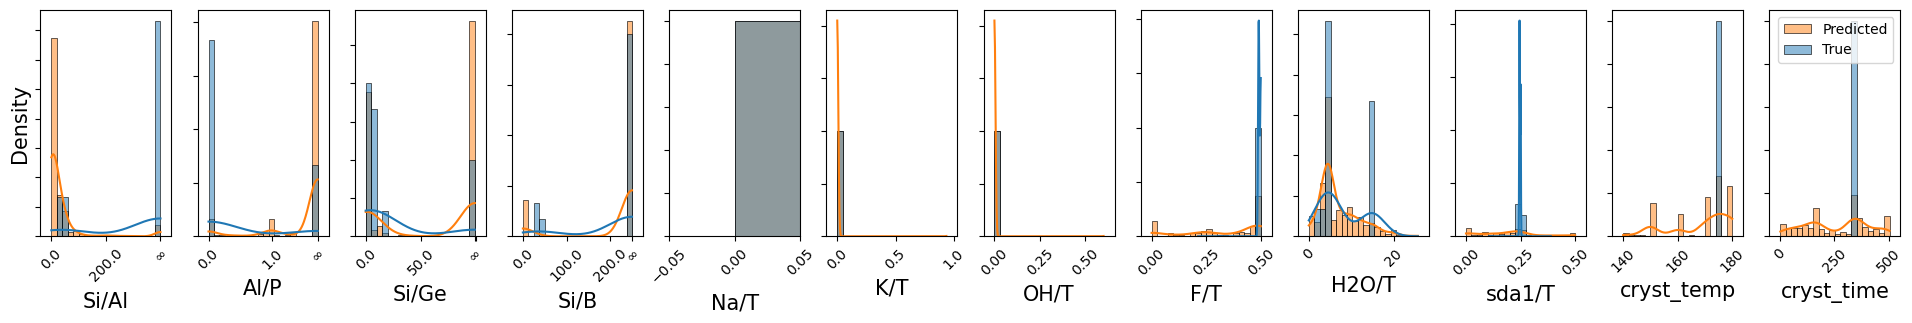

In [10]:
# Check BEC system for Si/Ge and F/T
zeo_osda_systems = list(syn_true[['zeo', 'osda']].value_counts().index)
count = 0
for zeo, osda in reversed(zeo_osda_systems):
    if zeo == 'BEC':
        print(zeo, osda)
        sys_syn_pred = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)]
        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], ['tab:orange', 'tab:blue'], kde=True, common_norm=True, alpha=0.5)
        
        count += 1
        if count > 50:
            break

In [11]:
sys_syn_pred

Si/Al      Al/P      Si/Ge   Si/B  Na/T  K/T  OH/T       F/T  \
4156      0.249978  1.717997   1.780311  250.0   0.0  0.0   0.0  0.095238   
4157      0.300000  1.717997   4.000000  250.0   0.0  0.0   0.0  0.117425   
4158    100.000000  1.717997  99.000000  250.0   0.0  0.0   0.0  0.500000   
4159      0.300000  1.717997  99.000000  250.0   0.0  0.0   0.0  0.495168   
4160      0.300000  1.717997   0.045316  250.0   0.0  0.0   0.0  0.250000   
...            ...       ...        ...    ...   ...  ...   ...       ...   
257398    8.091423  1.717997  99.000000  250.0   0.0  0.0   0.0  0.000000   
257399    6.493506  1.717997   2.000000  250.0   0.0  0.0   0.0  0.466014   
257400    6.493506  0.000000   0.000000  250.0   0.0  0.0   0.0  0.200551   
257401    0.819661  1.717997  99.000000  250.0   0.0  0.0   0.0  0.500000   
257402    5.000000  1.717997   1.955575  250.0   0.0  0.0   0.0  0.400000   

            H2O/T    sda1/T  cryst_temp  cryst_time  zeo  \
4156     9.748524  0.095396       175.0       168.0  BEC   
4157     8.333333  0.096774       175.0       168.0  BEC   
4158     3.000000  0.400000       160.0       360.0  BEC   
4159     5.000000  0.198966       170.0       168.0  BEC   
4160    11.250000  0.096774       180.0       336.0  BEC   
...           ...       ...         ...         ...  ...   
257398   3.500000  0.250000       150.0       336.0  BEC   
257399  10.250579  0.164618       175.0       408.0  BEC   
257400  11.459877  0.218711       170.0        24.0  BEC   
257401   4.545455  0.238095       160.0       240.0  BEC   
257402   8.695652  0.175086       175.0       336.0  BEC   

                                                 osda  
4156    C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31  
4157    C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31  
4158    C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31  
4159    C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31  
4160    C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31  
...                                               ...  
257398  C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31  
257399  C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31  
257400  C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31  
257401  C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31  
257402  C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31  

[750 rows x 14 columns]